In [ ]:
# Import libraries

# Data processing and manipulation
import pandas as pd
import numpy as np
from tqdm import tqdm
from collections import defaultdict
import matplotlib.pyplot as plt

from typing import Iterable, Any, Tuple, Dict


# Machine learning models
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, log_loss


# Custom models
import importlib
import sys, os
sys.path.insert(0, os.path.abspath(os.path.join(os.getcwd(), '../src')))

import preprocess_data as ppd
import GAMinferenceModels as gam_models

In [2]:
importlib.reload(ppd)
importlib.reload(gam_models)

<module 'GAMinferenceModels' from '/Users/malo/MIT Dropbox/Malo Lahogue/Research/Generator-outage-probability/src/GAMinferenceModels.py'>

# Prepare data

In [3]:
weather_data_file = "../Data/hourly/hourly_weather_by_state.csv"
power_load_file = "../Data/hourly/hourly_load_by_state.csv"
failure_data_file = "../Data/hourly/hourly_failure_dataset_compressed.csv"

feature_names_base = ppd.load_feature_bases(weather_data_file, power_load_file)
# feature_names_base = ['Temperature']
print(f"{len(feature_names_base)} initial features: {feature_names_base}")

# test_periods = [(pd.Timestamp('2022-01-01'), pd.Timestamp('2023-12-31'))]
test_periods = None

technologies = ['Gas Turbine/Jet Engine (Simple Cycle Operation)']


initial_state = 'all'

38 initial features: ['1d_load_sum', '24h_max_load', '24h_min_load', '2d_load_sum', 'CDD', 'CDD3d', 'DayOfWeek', 'DayOfYear', 'Dew_point_temperature', 'Extreme_cold', 'Extreme_heat', 'FDD', 'FDD3d', 'HDD', 'HDD3d', 'Heat_index', 'Holiday', 'Hourly_load_change', 'Load', 'Month', 'Precip_1d', 'Precip_3d', 'Precipitation', 'Pressure_3hr_change', 'Relative_humidity', 'Sea_level_pressure', 'Season', 'Snow_depth', 'State', 'Station_level_pressure', 'Temperature', 'Tmax', 'Tmean', 'Tmin', 'Weekend', 'Wet_bulb_temperature', 'Wind_chill', 'Wind_speed']


In [4]:
all_data_df, _, feature_names, target_columns, integer_encoding = ppd.preprocess_data(failure_data_path=failure_data_file,
                                                                                        weather_data_path=weather_data_file,
                                                                                        power_load_data_path=power_load_file,
                                                                                        feature_names=feature_names_base,
                                                                                        cyclic_features=["Season", "Month", "DayOfWeek", "DayOfYear"],
                                                                                        state_one_hot=True,
                                                                                        initial_MC_state_filter=initial_state,
                                                                                        technology_filter=technologies,
                                                                                        test_periods=test_periods
                                                                                        )



In [5]:
# Standardize all continuous features (exclude one-hots and raw categorical/cyclic markers)
exclude = {"Holiday", "Weekend", "Season", "Month", "DayOfWeek", "DayOfYear"}
stand_cols = [f for f in feature_names if not f.startswith("State_") and not f.startswith("Technology_") and not f.endswith("_isnan") and not f.endswith("_sin") and not f.endswith("_cos") and f not in exclude]
print(f"Standardized features ({len(stand_cols)}): {stand_cols}")

feature_names.sort()
stand_cols.sort()
target_columns.sort()

print(f"Encoding for 'Final_gen_state': {integer_encoding['Final_gen_state']}")

Standardized features (35): ['State', 'HDD', 'Wet_bulb_temperature', 'CDD', 'Hourly_load_change', '24h_max_load', 'Precipitation', 'Sea_level_pressure', 'Extreme_heat', 'Wind_chill', 'Wind_speed', 'Precip_1d', 'CDD3d', 'Station_level_pressure', 'Heat_index', 'Temperature', 'Precip_3d', 'Tmin', 'Snow_depth', 'Tmax', '1d_load_sum', 'Extreme_cold', 'Dew_point_temperature', 'Relative_humidity', '2d_load_sum', 'HDD3d', 'FDD3d', 'FDD', 'Tmean', '24h_min_load', 'Pressure_3hr_change', 'Load', 'Initial_gen_state', 'Temperature_3Dsum_hot', 'Temperature_3Dsum_cold']
Encoding for 'Final_gen_state': {'A': 0, 'D': 1, 'U': 2}


In [6]:
# temporal features for regional classifiers
all_data_df['month_sin'] = np.sin(2*np.pi*all_data_df['Datetime_UTC'].dt.month/12)
all_data_df['month_cos'] = np.cos(2*np.pi*all_data_df['Datetime_UTC'].dt.month/12)

In [7]:
# Get list of states from one-hot encoded columns
states_list = [f.split("_", 1)[1] for f in all_data_df.columns if f.startswith("State_")]

In [8]:
def get_data_splits(all_data_df, state, test_frac=0.2, seed=42):
    state_mask = all_data_df[f"State_{state}"] == 1
    train_df = all_data_df[~state_mask].copy().reset_index(drop=True)
    test_df = all_data_df[state_mask].copy().reset_index(drop=True)
    
    N = len(test_df)
    n_test = int(N*test_frac)
    # test_idx = np.random.choice(test_df.index, size=n_test, replace=False)
    test_idx = np.random.choice(N, size=n_test, replace=False)
    train_idx = test_df.index.difference(test_idx)
    if set(train_idx).intersection(set(test_idx)):
        raise ValueError("Train and test indices overlap!")
    train_df = pd.concat([train_df, test_df.iloc[train_idx]]).copy().reset_index(drop=True)
    test_df = test_df.iloc[test_idx].copy().reset_index(drop=True)

    # compute load cdf
    train_df['Load_CDF'] = ppd.load_cdf(train_df, train_df)
    test_df['Load_CDF'] = ppd.load_cdf(train_df, test_df)

    # stress modes
    T_nom = 25  # Nominal temperature in Celsius
    L_rated = 1.0  # Rated load in per unit (example value)

    #    train data
    temp_tr = train_df['Temperature'].values
    humid_tr = train_df['Relative_humidity'].values
    load_tr = train_df['Load_CDF'].values


    psi1_tr = gam_models.therm_load_stress(temp_tr, load_tr, T_nom=T_nom, L_rated=L_rated)
    psi2_tr = gam_models.cooling_stress(temp_tr, humid_tr)
    psi3_tr = train_df['Temperature_3Dsum_hot'].values
    psi4_tr = train_df['Temperature_3Dsum_cold'].values

    train_df['psi1'] = psi1_tr
    train_df['psi2'] = psi2_tr
    train_df['psi3'] = psi3_tr
    train_df['psi4'] = psi4_tr
    train_df['Stress'] = gam_models.composit_stress([psi1_tr, psi2_tr, psi3_tr, psi4_tr], weights=np.ones(4)/4)

    if train_df['Stress'].isna().any():
        raise ValueError(f"NaN values found in 'Stress' for training for state {state}!")

    #    test data
    temp_te = test_df['Temperature'].values
    humid_te = test_df['Relative_humidity'].values
    load_te = test_df['Load_CDF'].values

    psi1_te = gam_models.therm_load_stress(temp_te, load_te, T_nom=T_nom, L_rated=L_rated)
    psi2_te = gam_models.cooling_stress(temp_te, humid_te)
    psi3_te = test_df['Temperature_3Dsum_hot'].values
    psi4_te = test_df['Temperature_3Dsum_cold'].values

    test_df['psi1'] = psi1_te
    test_df['psi2'] = psi2_te
    test_df['psi3'] = psi3_te
    test_df['psi4'] = psi4_te
    test_df['Stress'] = gam_models.composit_stress([psi1_te, psi2_te, psi3_te, psi4_te], weights=np.ones(4)/4)

    if test_df['Stress'].isna().any():
        raise ValueError(f"NaN values found in 'Stress' for testing for state {state}!")

    return train_df, test_df

In [ ]:
test_frac = 0.2
for state in tqdm(states_list):
    train_df, test_df = get_data_splits(all_data_df, state, test_frac=test_frac, seed=42)

# Regional weights

## Regional classifiers

In [ ]:
classifier_feat = ['Temperature', 'Relative_humidity', 'Load_CDF', 'Temperature_3Dsum_hot', 'Temperature_3Dsum_cold', 'month_sin', 'month_cos']

score_states = defaultdict(lambda: defaultdict(float))

for state in tqdm(states_list):
    tr_data = train_df.copy()
    te_data = test_df.copy()
    clf = gam_models.regional_classifier(tr_data, state, classifier_feat)

    X_test = te_data[classifier_feat]
    y_test = (te_data['State'] == state).astype(int)

    p_test = clf.predict_proba(X_test)[:, 1]

    score_states[state]['roc_auc'] = roc_auc_score(y_test, p_test)
    score_states[state]['log_loss'] = log_loss(y_test, p_test)

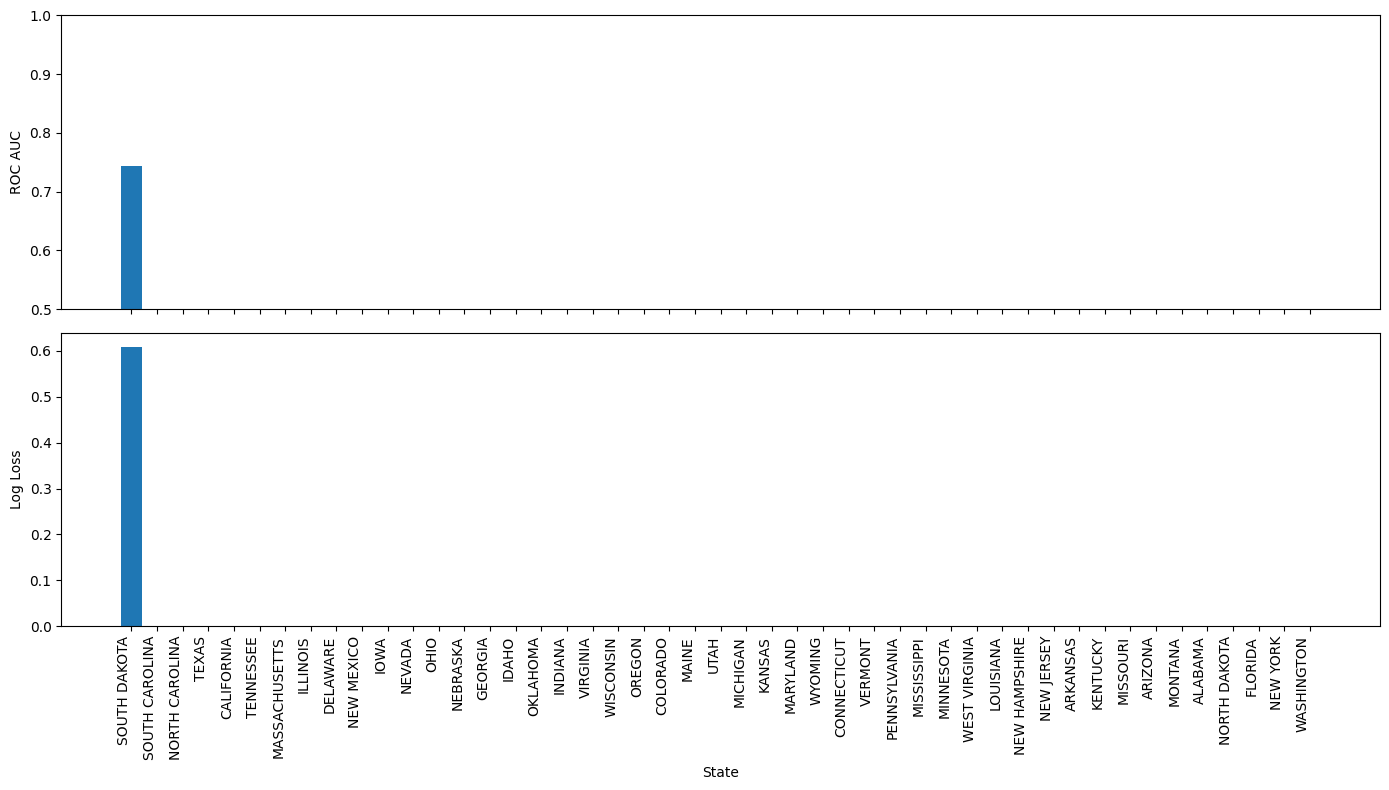

In [ ]:
# rank states by ROC AUC (descending) and plot with rotated x labels
sorted_states = sorted(states_list, key=lambda s: score_states[s]['roc_auc'], reverse=True)
roc_aucs_sorted = [score_states[s]['roc_auc'] for s in sorted_states]
log_losses_sorted = [score_states[s]['log_loss'] for s in sorted_states]

fig, ax = plt.subplots(2, 1, figsize=(14, 8), sharex=True)
x = np.arange(len(sorted_states))

ax[0].bar(x, roc_aucs_sorted)
ax[0].set_ylabel("ROC AUC")
ax[0].set_ylim(0.5, 1.0)

ax[1].bar(x, log_losses_sorted)
ax[1].set_ylabel("Log Loss")
ax[1].set_xlabel("State")
ax[1].set_xticks(x)
ax[1].set_xticklabels(sorted_states, rotation=90, ha='right')

plt.tight_layout()
plt.show()

# Train models per region

In [ ]:
importlib.reload(ppd)
importlib.reload(gam_models)

<module 'GAMinferenceModels' from '/Users/malo/MIT Dropbox/Malo Lahogue/Research/Generator-outage-probability/src/GAMinferenceModels.py'>

In [98]:
clipping_quantile = 0.95
gamma = 1.0
w_region = True
w_stress = True
test_frac = 0.2
classifier_feat = ['Temperature', 'Relative_humidity', 'Load_CDF', 'Temperature_3Dsum_hot', 'Temperature_3Dsum_cold', 'month_sin', 'month_cos']


transition_models = {}
test_datasets = {}
ess_res = {}

for state in tqdm(states_list):
    print(f"Training transition model for region: {state}")
    reg_train_data, reg_test_data = get_data_splits(all_data_df, state, test_frac=test_frac, seed=42)

    w_s = reg_test_data['Stress'].values
    w_max = np.quantile(w_s, 0.95)
    w_clipped = np.clip(w_s, None, w_max)
    w = w_clipped/w_clipped.mean()

    reg_test_data['w_stress'] = w

    test_datasets[state] = reg_test_data
    
    regional_train_data = reg_train_data.copy()
    regional_train_data['is_region'] = (regional_train_data['State'] == state).astype(int)
    r_w_func = gam_models.regional_weights_function(regional_train_data, state,
                                         classifier_features=classifier_feat)

    regional_train_data["w_region"] = r_w_func(regional_train_data)

    model, ess = gam_models.train_transition_model(regional_train_data, state,
                                                gamma=gamma,
                                                clipping_quantile=clipping_quantile,
                                                w_region=w_region,
                                                w_stress=w_stress,
                                                features_stage1=['Temperature', 'Load_CDF', 'psi1', 'psi2', 'psi3', 'psi4'],
                                                features_stage2=['psi1', 'psi2'],
                                                target_col='Final_gen_state',
                                                compressed_data_weight='Data_weight',
                                                verbose=False)

    transition_models[state] = model
    ess_res[state] = ess

  0%|          | 0/47 [00:00<?, ?it/s]

Training transition model for region: GEORGIA
ESS = 42.81926171019428 %

Processing initial MC state: 0


/Users/malo/miniconda3/envs/ScenarioGeneration/lib/python3.13/site-packages/pygam/links.py:148: RuntimeWarning: divide by zero encountered in divide
  return dist.levels / (mu * (dist.levels - mu))
/Users/malo/miniconda3/envs/ScenarioGeneration/lib/python3.13/site-packages/pygam/pygam.py:630: RuntimeWarning: invalid value encountered in multiply
  self.link.gradient(mu, self.distribution) ** 2
/Users/malo/miniconda3/envs/ScenarioGeneration/lib/python3.13/site-packages/pygam/pygam.py:630: RuntimeWarning: overflow encountered in square
  self.link.gradient(mu, self.distribution) ** 2
/Users/malo/miniconda3/envs/ScenarioGeneration/lib/python3.13/site-packages/pygam/links.py:132: RuntimeWarning: overflow encountered in exp
  elp = np.exp(lp)
/Users/malo/miniconda3/envs/ScenarioGeneration/lib/python3.13/site-packages/pygam/links.py:133: RuntimeWarning: invalid value encountered in divide
  return dist.levels * elp / (elp + 1)
/Users/malo/miniconda3/envs/ScenarioGeneration/lib/python3.13/sit

did not converge


/Users/malo/miniconda3/envs/ScenarioGeneration/lib/python3.13/site-packages/pygam/links.py:132: RuntimeWarning: overflow encountered in exp
  elp = np.exp(lp)
/Users/malo/miniconda3/envs/ScenarioGeneration/lib/python3.13/site-packages/pygam/links.py:133: RuntimeWarning: invalid value encountered in divide
  return dist.levels * elp / (elp + 1)
/Users/malo/miniconda3/envs/ScenarioGeneration/lib/python3.13/site-packages/pygam/links.py:148: RuntimeWarning: divide by zero encountered in divide
  return dist.levels / (mu * (dist.levels - mu))
/Users/malo/miniconda3/envs/ScenarioGeneration/lib/python3.13/site-packages/pygam/pygam.py:630: RuntimeWarning: invalid value encountered in multiply
  self.link.gradient(mu, self.distribution) ** 2
/Users/malo/miniconda3/envs/ScenarioGeneration/lib/python3.13/site-packages/pygam/links.py:148: RuntimeWarning: overflow encountered in divide
  return dist.levels / (mu * (dist.levels - mu))
/Users/malo/miniconda3/envs/ScenarioGeneration/lib/python3.13/sit


Processing initial MC state: 1

Processing initial MC state: 2


  2%|▏         | 1/47 [23:51<18:17:39, 1431.73s/it]

Training transition model for region: KENTUCKY
ESS = 48.74525258484052 %

Processing initial MC state: 0


/Users/malo/miniconda3/envs/ScenarioGeneration/lib/python3.13/site-packages/pygam/links.py:148: RuntimeWarning: divide by zero encountered in divide
  return dist.levels / (mu * (dist.levels - mu))
/Users/malo/miniconda3/envs/ScenarioGeneration/lib/python3.13/site-packages/pygam/pygam.py:630: RuntimeWarning: invalid value encountered in multiply
  self.link.gradient(mu, self.distribution) ** 2
/Users/malo/miniconda3/envs/ScenarioGeneration/lib/python3.13/site-packages/pygam/links.py:132: RuntimeWarning: overflow encountered in exp
  elp = np.exp(lp)
/Users/malo/miniconda3/envs/ScenarioGeneration/lib/python3.13/site-packages/pygam/links.py:133: RuntimeWarning: invalid value encountered in divide
  return dist.levels * elp / (elp + 1)
/Users/malo/miniconda3/envs/ScenarioGeneration/lib/python3.13/site-packages/pygam/pygam.py:630: RuntimeWarning: overflow encountered in square
  self.link.gradient(mu, self.distribution) ** 2
/Users/malo/miniconda3/envs/ScenarioGeneration/lib/python3.13/sit


Processing initial MC state: 1

Processing initial MC state: 2


  4%|▍         | 2/47 [39:14<14:09:25, 1132.58s/it]

Training transition model for region: OREGON
ESS = 41.77130432593518 %

Processing initial MC state: 0

Processing initial MC state: 1

Processing initial MC state: 2


  6%|▋         | 3/47 [53:52<12:25:20, 1016.36s/it]

Training transition model for region: MICHIGAN
ESS = 32.91317385587281 %

Processing initial MC state: 0

Processing initial MC state: 1

Processing initial MC state: 2


  9%|▊         | 4/47 [1:10:35<12:04:31, 1010.96s/it]

Training transition model for region: NEVADA
ESS = 26.708042544242637 %

Processing initial MC state: 0


/Users/malo/miniconda3/envs/ScenarioGeneration/lib/python3.13/site-packages/pygam/links.py:148: RuntimeWarning: divide by zero encountered in divide
  return dist.levels / (mu * (dist.levels - mu))
/Users/malo/miniconda3/envs/ScenarioGeneration/lib/python3.13/site-packages/pygam/pygam.py:630: RuntimeWarning: invalid value encountered in multiply
  self.link.gradient(mu, self.distribution) ** 2
/Users/malo/miniconda3/envs/ScenarioGeneration/lib/python3.13/site-packages/pygam/links.py:132: RuntimeWarning: overflow encountered in exp
  elp = np.exp(lp)
/Users/malo/miniconda3/envs/ScenarioGeneration/lib/python3.13/site-packages/pygam/links.py:133: RuntimeWarning: invalid value encountered in divide
  return dist.levels * elp / (elp + 1)
/Users/malo/miniconda3/envs/ScenarioGeneration/lib/python3.13/site-packages/pygam/links.py:148: RuntimeWarning: overflow encountered in divide
  return dist.levels / (mu * (dist.levels - mu))
/Users/malo/miniconda3/envs/ScenarioGeneration/lib/python3.13/sit


Processing initial MC state: 1

Processing initial MC state: 2


 11%|█         | 5/47 [1:25:05<11:11:59, 959.98s/it] 

Training transition model for region: ILLINOIS
ESS = 47.73422085620103 %

Processing initial MC state: 0


/Users/malo/miniconda3/envs/ScenarioGeneration/lib/python3.13/site-packages/pygam/links.py:148: RuntimeWarning: divide by zero encountered in divide
  return dist.levels / (mu * (dist.levels - mu))
/Users/malo/miniconda3/envs/ScenarioGeneration/lib/python3.13/site-packages/pygam/pygam.py:630: RuntimeWarning: invalid value encountered in multiply
  self.link.gradient(mu, self.distribution) ** 2
/Users/malo/miniconda3/envs/ScenarioGeneration/lib/python3.13/site-packages/pygam/pygam.py:630: RuntimeWarning: overflow encountered in square
  self.link.gradient(mu, self.distribution) ** 2
/Users/malo/miniconda3/envs/ScenarioGeneration/lib/python3.13/site-packages/pygam/links.py:132: RuntimeWarning: overflow encountered in exp
  elp = np.exp(lp)
/Users/malo/miniconda3/envs/ScenarioGeneration/lib/python3.13/site-packages/pygam/links.py:133: RuntimeWarning: invalid value encountered in divide
  return dist.levels * elp / (elp + 1)
/Users/malo/miniconda3/envs/ScenarioGeneration/lib/python3.13/sit


Processing initial MC state: 1

Processing initial MC state: 2


 13%|█▎        | 6/47 [1:40:45<10:51:18, 953.13s/it]

Training transition model for region: NEW MEXICO
ESS = 32.820604672439536 %

Processing initial MC state: 0


/Users/malo/miniconda3/envs/ScenarioGeneration/lib/python3.13/site-packages/pygam/pygam.py:630: RuntimeWarning: overflow encountered in square
  self.link.gradient(mu, self.distribution) ** 2
/Users/malo/miniconda3/envs/ScenarioGeneration/lib/python3.13/site-packages/pygam/links.py:148: RuntimeWarning: divide by zero encountered in divide
  return dist.levels / (mu * (dist.levels - mu))
/Users/malo/miniconda3/envs/ScenarioGeneration/lib/python3.13/site-packages/pygam/pygam.py:630: RuntimeWarning: invalid value encountered in multiply
  self.link.gradient(mu, self.distribution) ** 2
/Users/malo/miniconda3/envs/ScenarioGeneration/lib/python3.13/site-packages/pygam/links.py:132: RuntimeWarning: overflow encountered in exp
  elp = np.exp(lp)
/Users/malo/miniconda3/envs/ScenarioGeneration/lib/python3.13/site-packages/pygam/links.py:133: RuntimeWarning: invalid value encountered in divide
  return dist.levels * elp / (elp + 1)
/Users/malo/miniconda3/envs/ScenarioGeneration/lib/python3.13/sit


Processing initial MC state: 1

Processing initial MC state: 2


 15%|█▍        | 7/47 [1:56:08<10:28:56, 943.42s/it]

Training transition model for region: MARYLAND
ESS = 53.41706574086684 %

Processing initial MC state: 0


/Users/malo/miniconda3/envs/ScenarioGeneration/lib/python3.13/site-packages/pygam/links.py:148: RuntimeWarning: divide by zero encountered in divide
  return dist.levels / (mu * (dist.levels - mu))
/Users/malo/miniconda3/envs/ScenarioGeneration/lib/python3.13/site-packages/pygam/pygam.py:630: RuntimeWarning: invalid value encountered in multiply
  self.link.gradient(mu, self.distribution) ** 2
/Users/malo/miniconda3/envs/ScenarioGeneration/lib/python3.13/site-packages/pygam/links.py:132: RuntimeWarning: overflow encountered in exp
  elp = np.exp(lp)
/Users/malo/miniconda3/envs/ScenarioGeneration/lib/python3.13/site-packages/pygam/links.py:133: RuntimeWarning: invalid value encountered in divide
  return dist.levels * elp / (elp + 1)
/Users/malo/miniconda3/envs/ScenarioGeneration/lib/python3.13/site-packages/pygam/links.py:148: RuntimeWarning: overflow encountered in divide
  return dist.levels / (mu * (dist.levels - mu))
/Users/malo/miniconda3/envs/ScenarioGeneration/lib/python3.13/sit


Processing initial MC state: 1

Processing initial MC state: 2


 17%|█▋        | 8/47 [2:12:22<10:19:30, 953.09s/it]

Training transition model for region: NEW HAMPSHIRE
ESS = 37.986611330876585 %

Processing initial MC state: 0

Processing initial MC state: 1

Processing initial MC state: 2


 19%|█▉        | 9/47 [2:27:08<9:50:24, 932.21s/it] 

Training transition model for region: SOUTH CAROLINA
ESS = 47.336641836995916 %

Processing initial MC state: 0


/Users/malo/miniconda3/envs/ScenarioGeneration/lib/python3.13/site-packages/pygam/links.py:148: RuntimeWarning: divide by zero encountered in divide
  return dist.levels / (mu * (dist.levels - mu))
/Users/malo/miniconda3/envs/ScenarioGeneration/lib/python3.13/site-packages/pygam/pygam.py:630: RuntimeWarning: invalid value encountered in multiply
  self.link.gradient(mu, self.distribution) ** 2
/Users/malo/miniconda3/envs/ScenarioGeneration/lib/python3.13/site-packages/pygam/links.py:148: RuntimeWarning: overflow encountered in divide
  return dist.levels / (mu * (dist.levels - mu))
/Users/malo/miniconda3/envs/ScenarioGeneration/lib/python3.13/site-packages/pygam/pygam.py:630: RuntimeWarning: overflow encountered in square
  self.link.gradient(mu, self.distribution) ** 2
/Users/malo/miniconda3/envs/ScenarioGeneration/lib/python3.13/site-packages/pygam/links.py:132: RuntimeWarning: overflow encountered in exp
  elp = np.exp(lp)
/Users/malo/miniconda3/envs/ScenarioGeneration/lib/python3.1


Processing initial MC state: 1

Processing initial MC state: 2


 21%|██▏       | 10/47 [2:47:30<10:30:04, 1021.75s/it]

Training transition model for region: MASSACHUSETTS
ESS = 45.045889886780344 %

Processing initial MC state: 0

Processing initial MC state: 1

Processing initial MC state: 2


 23%|██▎       | 11/47 [3:01:43<9:41:54, 969.86s/it]  

Training transition model for region: MINNESOTA
ESS = 33.664635558880114 %

Processing initial MC state: 0

Processing initial MC state: 1

Processing initial MC state: 2


 26%|██▌       | 12/47 [3:17:53<9:25:49, 970.00s/it]

Training transition model for region: NEBRASKA
ESS = 37.74415241568528 %

Processing initial MC state: 0


/Users/malo/miniconda3/envs/ScenarioGeneration/lib/python3.13/site-packages/pygam/pygam.py:630: RuntimeWarning: overflow encountered in square
  self.link.gradient(mu, self.distribution) ** 2
/Users/malo/miniconda3/envs/ScenarioGeneration/lib/python3.13/site-packages/pygam/links.py:148: RuntimeWarning: divide by zero encountered in divide
  return dist.levels / (mu * (dist.levels - mu))
/Users/malo/miniconda3/envs/ScenarioGeneration/lib/python3.13/site-packages/pygam/pygam.py:630: RuntimeWarning: invalid value encountered in multiply
  self.link.gradient(mu, self.distribution) ** 2
/Users/malo/miniconda3/envs/ScenarioGeneration/lib/python3.13/site-packages/pygam/links.py:132: RuntimeWarning: overflow encountered in exp
  elp = np.exp(lp)
/Users/malo/miniconda3/envs/ScenarioGeneration/lib/python3.13/site-packages/pygam/links.py:133: RuntimeWarning: invalid value encountered in divide
  return dist.levels * elp / (elp + 1)
/Users/malo/miniconda3/envs/ScenarioGeneration/lib/python3.13/sit


Processing initial MC state: 1

Processing initial MC state: 2


 28%|██▊       | 13/47 [3:32:35<8:54:32, 943.29s/it]

Training transition model for region: SOUTH DAKOTA
ESS = 39.268997091395605 %

Processing initial MC state: 0


/Users/malo/miniconda3/envs/ScenarioGeneration/lib/python3.13/site-packages/pygam/links.py:148: RuntimeWarning: divide by zero encountered in divide
  return dist.levels / (mu * (dist.levels - mu))
/Users/malo/miniconda3/envs/ScenarioGeneration/lib/python3.13/site-packages/pygam/pygam.py:630: RuntimeWarning: invalid value encountered in multiply
  self.link.gradient(mu, self.distribution) ** 2
/Users/malo/miniconda3/envs/ScenarioGeneration/lib/python3.13/site-packages/pygam/links.py:148: RuntimeWarning: overflow encountered in divide
  return dist.levels / (mu * (dist.levels - mu))
/Users/malo/miniconda3/envs/ScenarioGeneration/lib/python3.13/site-packages/pygam/pygam.py:630: RuntimeWarning: overflow encountered in square
  self.link.gradient(mu, self.distribution) ** 2
/Users/malo/miniconda3/envs/ScenarioGeneration/lib/python3.13/site-packages/pygam/links.py:132: RuntimeWarning: overflow encountered in exp
  elp = np.exp(lp)
/Users/malo/miniconda3/envs/ScenarioGeneration/lib/python3.1


Processing initial MC state: 1

Processing initial MC state: 2


 30%|██▉       | 14/47 [3:48:18<8:38:51, 943.37s/it]

Training transition model for region: WYOMING
ESS = 21.77729881581314 %

Processing initial MC state: 0


/Users/malo/miniconda3/envs/ScenarioGeneration/lib/python3.13/site-packages/pygam/links.py:148: RuntimeWarning: divide by zero encountered in divide
  return dist.levels / (mu * (dist.levels - mu))
/Users/malo/miniconda3/envs/ScenarioGeneration/lib/python3.13/site-packages/pygam/pygam.py:630: RuntimeWarning: invalid value encountered in multiply
  self.link.gradient(mu, self.distribution) ** 2
/Users/malo/miniconda3/envs/ScenarioGeneration/lib/python3.13/site-packages/pygam/links.py:132: RuntimeWarning: overflow encountered in exp
  elp = np.exp(lp)
/Users/malo/miniconda3/envs/ScenarioGeneration/lib/python3.13/site-packages/pygam/links.py:133: RuntimeWarning: invalid value encountered in divide
  return dist.levels * elp / (elp + 1)
/Users/malo/miniconda3/envs/ScenarioGeneration/lib/python3.13/site-packages/pygam/links.py:148: RuntimeWarning: overflow encountered in divide
  return dist.levels / (mu * (dist.levels - mu))
/Users/malo/miniconda3/envs/ScenarioGeneration/lib/python3.13/sit


Processing initial MC state: 1

Processing initial MC state: 2


 32%|███▏      | 15/47 [4:02:49<8:11:24, 921.40s/it]

Training transition model for region: ARIZONA
ESS = 26.222037857359474 %

Processing initial MC state: 0


/Users/malo/miniconda3/envs/ScenarioGeneration/lib/python3.13/site-packages/pygam/links.py:148: RuntimeWarning: divide by zero encountered in divide
  return dist.levels / (mu * (dist.levels - mu))
/Users/malo/miniconda3/envs/ScenarioGeneration/lib/python3.13/site-packages/pygam/pygam.py:630: RuntimeWarning: invalid value encountered in multiply
  self.link.gradient(mu, self.distribution) ** 2
/Users/malo/miniconda3/envs/ScenarioGeneration/lib/python3.13/site-packages/pygam/pygam.py:630: RuntimeWarning: overflow encountered in square
  self.link.gradient(mu, self.distribution) ** 2
/Users/malo/miniconda3/envs/ScenarioGeneration/lib/python3.13/site-packages/pygam/links.py:148: RuntimeWarning: overflow encountered in divide
  return dist.levels / (mu * (dist.levels - mu))
/Users/malo/miniconda3/envs/ScenarioGeneration/lib/python3.13/site-packages/pygam/links.py:132: RuntimeWarning: overflow encountered in exp
  elp = np.exp(lp)
/Users/malo/miniconda3/envs/ScenarioGeneration/lib/python3.1

did not converge

Processing initial MC state: 1

Processing initial MC state: 2


 34%|███▍      | 16/47 [4:17:21<7:48:25, 906.64s/it]

Training transition model for region: IOWA
ESS = 44.441170383058655 %

Processing initial MC state: 0


/Users/malo/miniconda3/envs/ScenarioGeneration/lib/python3.13/site-packages/pygam/links.py:148: RuntimeWarning: divide by zero encountered in divide
  return dist.levels / (mu * (dist.levels - mu))
/Users/malo/miniconda3/envs/ScenarioGeneration/lib/python3.13/site-packages/pygam/pygam.py:630: RuntimeWarning: invalid value encountered in multiply
  self.link.gradient(mu, self.distribution) ** 2
/Users/malo/miniconda3/envs/ScenarioGeneration/lib/python3.13/site-packages/pygam/pygam.py:630: RuntimeWarning: overflow encountered in square
  self.link.gradient(mu, self.distribution) ** 2
/Users/malo/miniconda3/envs/ScenarioGeneration/lib/python3.13/site-packages/pygam/links.py:132: RuntimeWarning: overflow encountered in exp
  elp = np.exp(lp)
/Users/malo/miniconda3/envs/ScenarioGeneration/lib/python3.13/site-packages/pygam/links.py:133: RuntimeWarning: invalid value encountered in divide
  return dist.levels * elp / (elp + 1)
/Users/malo/miniconda3/envs/ScenarioGeneration/lib/python3.13/sit

did not converge

Processing initial MC state: 1

Processing initial MC state: 2


 36%|███▌      | 17/47 [4:32:14<7:31:19, 902.65s/it]

Training transition model for region: WASHINGTON
ESS = 40.74832473561074 %

Processing initial MC state: 0

Processing initial MC state: 1

Processing initial MC state: 2


 38%|███▊      | 18/47 [4:47:29<7:17:59, 906.19s/it]

Training transition model for region: MAINE
ESS = 27.42799348382874 %

Processing initial MC state: 0

Processing initial MC state: 1

Processing initial MC state: 2


 40%|████      | 19/47 [5:02:19<7:00:40, 901.46s/it]

Training transition model for region: IDAHO
ESS = 30.43520890566606 %

Processing initial MC state: 0


/Users/malo/miniconda3/envs/ScenarioGeneration/lib/python3.13/site-packages/pygam/links.py:148: RuntimeWarning: divide by zero encountered in divide
  return dist.levels / (mu * (dist.levels - mu))
/Users/malo/miniconda3/envs/ScenarioGeneration/lib/python3.13/site-packages/pygam/pygam.py:630: RuntimeWarning: invalid value encountered in multiply
  self.link.gradient(mu, self.distribution) ** 2
/Users/malo/miniconda3/envs/ScenarioGeneration/lib/python3.13/site-packages/pygam/links.py:132: RuntimeWarning: overflow encountered in exp
  elp = np.exp(lp)
/Users/malo/miniconda3/envs/ScenarioGeneration/lib/python3.13/site-packages/pygam/links.py:133: RuntimeWarning: invalid value encountered in divide
  return dist.levels * elp / (elp + 1)
/Users/malo/miniconda3/envs/ScenarioGeneration/lib/python3.13/site-packages/pygam/pygam.py:630: RuntimeWarning: overflow encountered in square
  self.link.gradient(mu, self.distribution) ** 2
/Users/malo/miniconda3/envs/ScenarioGeneration/lib/python3.13/sit

did not converge

Processing initial MC state: 1

Processing initial MC state: 2


 43%|████▎     | 20/47 [5:16:58<6:42:31, 894.50s/it]

Training transition model for region: WEST VIRGINIA
ESS = 56.70836401031779 %

Processing initial MC state: 0

Processing initial MC state: 1

Processing initial MC state: 2


 45%|████▍     | 21/47 [5:32:15<6:30:38, 901.49s/it]

Training transition model for region: COLORADO
ESS = 22.585497845761925 %

Processing initial MC state: 0


/Users/malo/miniconda3/envs/ScenarioGeneration/lib/python3.13/site-packages/pygam/links.py:148: RuntimeWarning: divide by zero encountered in divide
  return dist.levels / (mu * (dist.levels - mu))
/Users/malo/miniconda3/envs/ScenarioGeneration/lib/python3.13/site-packages/pygam/pygam.py:630: RuntimeWarning: invalid value encountered in multiply
  self.link.gradient(mu, self.distribution) ** 2
/Users/malo/miniconda3/envs/ScenarioGeneration/lib/python3.13/site-packages/pygam/links.py:132: RuntimeWarning: overflow encountered in exp
  elp = np.exp(lp)
/Users/malo/miniconda3/envs/ScenarioGeneration/lib/python3.13/site-packages/pygam/links.py:133: RuntimeWarning: invalid value encountered in divide
  return dist.levels * elp / (elp + 1)
/Users/malo/miniconda3/envs/ScenarioGeneration/lib/python3.13/site-packages/pygam/links.py:148: RuntimeWarning: overflow encountered in divide
  return dist.levels / (mu * (dist.levels - mu))
/Users/malo/miniconda3/envs/ScenarioGeneration/lib/python3.13/sit


Processing initial MC state: 1

Processing initial MC state: 2


 47%|████▋     | 22/47 [5:46:18<6:08:13, 883.73s/it]

Training transition model for region: ARKANSAS
ESS = 49.00909645947805 %

Processing initial MC state: 0


/Users/malo/miniconda3/envs/ScenarioGeneration/lib/python3.13/site-packages/pygam/links.py:148: RuntimeWarning: divide by zero encountered in divide
  return dist.levels / (mu * (dist.levels - mu))
/Users/malo/miniconda3/envs/ScenarioGeneration/lib/python3.13/site-packages/pygam/pygam.py:630: RuntimeWarning: invalid value encountered in multiply
  self.link.gradient(mu, self.distribution) ** 2
/Users/malo/miniconda3/envs/ScenarioGeneration/lib/python3.13/site-packages/pygam/links.py:132: RuntimeWarning: overflow encountered in exp
  elp = np.exp(lp)
/Users/malo/miniconda3/envs/ScenarioGeneration/lib/python3.13/site-packages/pygam/links.py:133: RuntimeWarning: invalid value encountered in divide
  return dist.levels * elp / (elp + 1)
/Users/malo/miniconda3/envs/ScenarioGeneration/lib/python3.13/site-packages/pygam/pygam.py:630: RuntimeWarning: overflow encountered in square
  self.link.gradient(mu, self.distribution) ** 2
/Users/malo/miniconda3/envs/ScenarioGeneration/lib/python3.13/sit


Processing initial MC state: 1

Processing initial MC state: 2


 49%|████▉     | 23/47 [6:01:26<5:56:24, 891.03s/it]

Training transition model for region: CONNECTICUT
ESS = 50.23469745599544 %

Processing initial MC state: 0

Processing initial MC state: 1

Processing initial MC state: 2


 51%|█████     | 24/47 [6:19:23<6:02:59, 946.92s/it]

Training transition model for region: INDIANA
ESS = 51.88901010932687 %

Processing initial MC state: 0

Processing initial MC state: 1

Processing initial MC state: 2


 53%|█████▎    | 25/47 [6:35:17<5:48:01, 949.16s/it]

Training transition model for region: VERMONT
ESS = 32.472864335151385 %

Processing initial MC state: 0

Processing initial MC state: 1

Processing initial MC state: 2


 55%|█████▌    | 26/47 [6:51:56<5:37:21, 963.86s/it]

Training transition model for region: LOUISIANA
ESS = 29.039781523006653 %

Processing initial MC state: 0


/Users/malo/miniconda3/envs/ScenarioGeneration/lib/python3.13/site-packages/pygam/links.py:148: RuntimeWarning: divide by zero encountered in divide
  return dist.levels / (mu * (dist.levels - mu))
/Users/malo/miniconda3/envs/ScenarioGeneration/lib/python3.13/site-packages/pygam/pygam.py:630: RuntimeWarning: invalid value encountered in multiply
  self.link.gradient(mu, self.distribution) ** 2
/Users/malo/miniconda3/envs/ScenarioGeneration/lib/python3.13/site-packages/pygam/links.py:132: RuntimeWarning: overflow encountered in exp
  elp = np.exp(lp)
/Users/malo/miniconda3/envs/ScenarioGeneration/lib/python3.13/site-packages/pygam/links.py:133: RuntimeWarning: invalid value encountered in divide
  return dist.levels * elp / (elp + 1)
/Users/malo/miniconda3/envs/ScenarioGeneration/lib/python3.13/site-packages/pygam/links.py:148: RuntimeWarning: overflow encountered in divide
  return dist.levels / (mu * (dist.levels - mu))
/Users/malo/miniconda3/envs/ScenarioGeneration/lib/python3.13/sit

did not converge

Processing initial MC state: 1

Processing initial MC state: 2


 57%|█████▋    | 27/47 [7:11:07<5:40:03, 1020.18s/it]

Training transition model for region: OKLAHOMA
ESS = 43.586629929107644 %

Processing initial MC state: 0


/Users/malo/miniconda3/envs/ScenarioGeneration/lib/python3.13/site-packages/pygam/links.py:148: RuntimeWarning: divide by zero encountered in divide
  return dist.levels / (mu * (dist.levels - mu))
/Users/malo/miniconda3/envs/ScenarioGeneration/lib/python3.13/site-packages/pygam/pygam.py:630: RuntimeWarning: invalid value encountered in multiply
  self.link.gradient(mu, self.distribution) ** 2
/Users/malo/miniconda3/envs/ScenarioGeneration/lib/python3.13/site-packages/pygam/links.py:148: RuntimeWarning: overflow encountered in divide
  return dist.levels / (mu * (dist.levels - mu))
/Users/malo/miniconda3/envs/ScenarioGeneration/lib/python3.13/site-packages/pygam/pygam.py:630: RuntimeWarning: overflow encountered in square
  self.link.gradient(mu, self.distribution) ** 2
/Users/malo/miniconda3/envs/ScenarioGeneration/lib/python3.13/site-packages/pygam/links.py:132: RuntimeWarning: overflow encountered in exp
  elp = np.exp(lp)
/Users/malo/miniconda3/envs/ScenarioGeneration/lib/python3.1


Processing initial MC state: 1

Processing initial MC state: 2


 60%|█████▉    | 28/47 [7:26:39<5:14:41, 993.78s/it] 

Training transition model for region: NEW YORK
ESS = 42.26715194246322 %

Processing initial MC state: 0

Processing initial MC state: 1

Processing initial MC state: 2


 62%|██████▏   | 29/47 [7:42:19<4:53:17, 977.63s/it]

Training transition model for region: NORTH DAKOTA
ESS = 31.777291662005986 %

Processing initial MC state: 0

Processing initial MC state: 1

Processing initial MC state: 2


 64%|██████▍   | 30/47 [7:58:33<4:36:41, 976.57s/it]

Training transition model for region: WISCONSIN
ESS = 33.07964228499148 %

Processing initial MC state: 0

Processing initial MC state: 1

Processing initial MC state: 2


 66%|██████▌   | 31/47 [8:15:34<4:23:55, 989.73s/it]

Training transition model for region: TEXAS
ESS = 34.038365839561116 %

Processing initial MC state: 0


/Users/malo/miniconda3/envs/ScenarioGeneration/lib/python3.13/site-packages/pygam/links.py:148: RuntimeWarning: divide by zero encountered in divide
  return dist.levels / (mu * (dist.levels - mu))
/Users/malo/miniconda3/envs/ScenarioGeneration/lib/python3.13/site-packages/pygam/pygam.py:630: RuntimeWarning: invalid value encountered in multiply
  self.link.gradient(mu, self.distribution) ** 2
/Users/malo/miniconda3/envs/ScenarioGeneration/lib/python3.13/site-packages/pygam/links.py:132: RuntimeWarning: overflow encountered in exp
  elp = np.exp(lp)
/Users/malo/miniconda3/envs/ScenarioGeneration/lib/python3.13/site-packages/pygam/links.py:133: RuntimeWarning: invalid value encountered in divide
  return dist.levels * elp / (elp + 1)
/Users/malo/miniconda3/envs/ScenarioGeneration/lib/python3.13/site-packages/pygam/links.py:148: RuntimeWarning: overflow encountered in divide
  return dist.levels / (mu * (dist.levels - mu))
/Users/malo/miniconda3/envs/ScenarioGeneration/lib/python3.13/sit


Processing initial MC state: 1

Processing initial MC state: 2


 68%|██████▊   | 32/47 [8:32:14<4:08:11, 992.73s/it]

Training transition model for region: VIRGINIA
ESS = 52.39440013552267 %

Processing initial MC state: 0


/Users/malo/miniconda3/envs/ScenarioGeneration/lib/python3.13/site-packages/pygam/links.py:148: RuntimeWarning: divide by zero encountered in divide
  return dist.levels / (mu * (dist.levels - mu))
/Users/malo/miniconda3/envs/ScenarioGeneration/lib/python3.13/site-packages/pygam/pygam.py:630: RuntimeWarning: invalid value encountered in multiply
  self.link.gradient(mu, self.distribution) ** 2
/Users/malo/miniconda3/envs/ScenarioGeneration/lib/python3.13/site-packages/pygam/links.py:132: RuntimeWarning: overflow encountered in exp
  elp = np.exp(lp)
/Users/malo/miniconda3/envs/ScenarioGeneration/lib/python3.13/site-packages/pygam/links.py:133: RuntimeWarning: invalid value encountered in divide
  return dist.levels * elp / (elp + 1)
/Users/malo/miniconda3/envs/ScenarioGeneration/lib/python3.13/site-packages/pygam/pygam.py:630: RuntimeWarning: overflow encountered in square
  self.link.gradient(mu, self.distribution) ** 2
/Users/malo/miniconda3/envs/ScenarioGeneration/lib/python3.13/sit


Processing initial MC state: 1

Processing initial MC state: 2


 70%|███████   | 33/47 [8:50:00<3:56:46, 1014.72s/it]

Training transition model for region: UTAH
ESS = 26.07695665343792 %

Processing initial MC state: 0


/Users/malo/miniconda3/envs/ScenarioGeneration/lib/python3.13/site-packages/pygam/links.py:148: RuntimeWarning: divide by zero encountered in divide
  return dist.levels / (mu * (dist.levels - mu))
/Users/malo/miniconda3/envs/ScenarioGeneration/lib/python3.13/site-packages/pygam/pygam.py:630: RuntimeWarning: invalid value encountered in multiply
  self.link.gradient(mu, self.distribution) ** 2
/Users/malo/miniconda3/envs/ScenarioGeneration/lib/python3.13/site-packages/pygam/links.py:132: RuntimeWarning: overflow encountered in exp
  elp = np.exp(lp)
/Users/malo/miniconda3/envs/ScenarioGeneration/lib/python3.13/site-packages/pygam/links.py:133: RuntimeWarning: invalid value encountered in divide
  return dist.levels * elp / (elp + 1)
/Users/malo/miniconda3/envs/ScenarioGeneration/lib/python3.13/site-packages/pygam/links.py:148: RuntimeWarning: overflow encountered in divide
  return dist.levels / (mu * (dist.levels - mu))
/Users/malo/miniconda3/envs/ScenarioGeneration/lib/python3.13/sit


Processing initial MC state: 1

Processing initial MC state: 2


 72%|███████▏  | 34/47 [9:04:35<3:30:47, 972.86s/it] 

Training transition model for region: DELAWARE
ESS = 53.609133005257256 %

Processing initial MC state: 0


/Users/malo/miniconda3/envs/ScenarioGeneration/lib/python3.13/site-packages/pygam/links.py:148: RuntimeWarning: divide by zero encountered in divide
  return dist.levels / (mu * (dist.levels - mu))
/Users/malo/miniconda3/envs/ScenarioGeneration/lib/python3.13/site-packages/pygam/pygam.py:630: RuntimeWarning: invalid value encountered in multiply
  self.link.gradient(mu, self.distribution) ** 2
/Users/malo/miniconda3/envs/ScenarioGeneration/lib/python3.13/site-packages/pygam/links.py:132: RuntimeWarning: overflow encountered in exp
  elp = np.exp(lp)
/Users/malo/miniconda3/envs/ScenarioGeneration/lib/python3.13/site-packages/pygam/links.py:133: RuntimeWarning: invalid value encountered in divide
  return dist.levels * elp / (elp + 1)
/Users/malo/miniconda3/envs/ScenarioGeneration/lib/python3.13/site-packages/pygam/pygam.py:630: RuntimeWarning: overflow encountered in square
  self.link.gradient(mu, self.distribution) ** 2
/Users/malo/miniconda3/envs/ScenarioGeneration/lib/python3.13/sit

did not converge

Processing initial MC state: 1

Processing initial MC state: 2


 74%|███████▍  | 35/47 [9:19:22<3:09:27, 947.26s/it]

Training transition model for region: OHIO
ESS = 52.87452728521971 %

Processing initial MC state: 0

Processing initial MC state: 1

Processing initial MC state: 2


 77%|███████▋  | 36/47 [9:34:27<2:51:18, 934.40s/it]

Training transition model for region: TENNESSEE
ESS = 52.62140545003863 %

Processing initial MC state: 0


/Users/malo/miniconda3/envs/ScenarioGeneration/lib/python3.13/site-packages/pygam/links.py:148: RuntimeWarning: divide by zero encountered in divide
  return dist.levels / (mu * (dist.levels - mu))
/Users/malo/miniconda3/envs/ScenarioGeneration/lib/python3.13/site-packages/pygam/pygam.py:630: RuntimeWarning: invalid value encountered in multiply
  self.link.gradient(mu, self.distribution) ** 2
/Users/malo/miniconda3/envs/ScenarioGeneration/lib/python3.13/site-packages/pygam/links.py:132: RuntimeWarning: overflow encountered in exp
  elp = np.exp(lp)
/Users/malo/miniconda3/envs/ScenarioGeneration/lib/python3.13/site-packages/pygam/links.py:133: RuntimeWarning: invalid value encountered in divide
  return dist.levels * elp / (elp + 1)
/Users/malo/miniconda3/envs/ScenarioGeneration/lib/python3.13/site-packages/pygam/links.py:148: RuntimeWarning: overflow encountered in divide
  return dist.levels / (mu * (dist.levels - mu))
/Users/malo/miniconda3/envs/ScenarioGeneration/lib/python3.13/sit


Processing initial MC state: 1

Processing initial MC state: 2


 79%|███████▊  | 37/47 [9:51:08<2:39:04, 954.44s/it]

Training transition model for region: KANSAS
ESS = 39.061541676502955 %

Processing initial MC state: 0


/Users/malo/miniconda3/envs/ScenarioGeneration/lib/python3.13/site-packages/pygam/links.py:148: RuntimeWarning: divide by zero encountered in divide
  return dist.levels / (mu * (dist.levels - mu))
/Users/malo/miniconda3/envs/ScenarioGeneration/lib/python3.13/site-packages/pygam/pygam.py:630: RuntimeWarning: invalid value encountered in multiply
  self.link.gradient(mu, self.distribution) ** 2
/Users/malo/miniconda3/envs/ScenarioGeneration/lib/python3.13/site-packages/pygam/links.py:148: RuntimeWarning: overflow encountered in divide
  return dist.levels / (mu * (dist.levels - mu))
/Users/malo/miniconda3/envs/ScenarioGeneration/lib/python3.13/site-packages/pygam/pygam.py:630: RuntimeWarning: overflow encountered in square
  self.link.gradient(mu, self.distribution) ** 2
/Users/malo/miniconda3/envs/ScenarioGeneration/lib/python3.13/site-packages/pygam/links.py:132: RuntimeWarning: overflow encountered in exp
  elp = np.exp(lp)
/Users/malo/miniconda3/envs/ScenarioGeneration/lib/python3.1


Processing initial MC state: 1

Processing initial MC state: 2


 81%|████████  | 38/47 [10:07:50<2:25:18, 968.76s/it]

Training transition model for region: MISSOURI
ESS = 44.271526700616654 %

Processing initial MC state: 0


/Users/malo/miniconda3/envs/ScenarioGeneration/lib/python3.13/site-packages/pygam/links.py:148: RuntimeWarning: divide by zero encountered in divide
  return dist.levels / (mu * (dist.levels - mu))
/Users/malo/miniconda3/envs/ScenarioGeneration/lib/python3.13/site-packages/pygam/pygam.py:630: RuntimeWarning: invalid value encountered in multiply
  self.link.gradient(mu, self.distribution) ** 2
/Users/malo/miniconda3/envs/ScenarioGeneration/lib/python3.13/site-packages/pygam/links.py:148: RuntimeWarning: overflow encountered in divide
  return dist.levels / (mu * (dist.levels - mu))
/Users/malo/miniconda3/envs/ScenarioGeneration/lib/python3.13/site-packages/pygam/pygam.py:630: RuntimeWarning: overflow encountered in square
  self.link.gradient(mu, self.distribution) ** 2
/Users/malo/miniconda3/envs/ScenarioGeneration/lib/python3.13/site-packages/pygam/links.py:132: RuntimeWarning: overflow encountered in exp
  elp = np.exp(lp)
/Users/malo/miniconda3/envs/ScenarioGeneration/lib/python3.1


Processing initial MC state: 1

Processing initial MC state: 2


 83%|████████▎ | 39/47 [10:26:41<2:15:38, 1017.29s/it]

Training transition model for region: FLORIDA
ESS = 21.40707028711867 %

Processing initial MC state: 0


/Users/malo/miniconda3/envs/ScenarioGeneration/lib/python3.13/site-packages/pygam/links.py:148: RuntimeWarning: divide by zero encountered in divide
  return dist.levels / (mu * (dist.levels - mu))
/Users/malo/miniconda3/envs/ScenarioGeneration/lib/python3.13/site-packages/pygam/pygam.py:630: RuntimeWarning: invalid value encountered in multiply
  self.link.gradient(mu, self.distribution) ** 2
/Users/malo/miniconda3/envs/ScenarioGeneration/lib/python3.13/site-packages/pygam/pygam.py:630: RuntimeWarning: overflow encountered in square
  self.link.gradient(mu, self.distribution) ** 2
/Users/malo/miniconda3/envs/ScenarioGeneration/lib/python3.13/site-packages/pygam/links.py:132: RuntimeWarning: overflow encountered in exp
  elp = np.exp(lp)
/Users/malo/miniconda3/envs/ScenarioGeneration/lib/python3.13/site-packages/pygam/links.py:133: RuntimeWarning: invalid value encountered in divide
  return dist.levels * elp / (elp + 1)
/Users/malo/miniconda3/envs/ScenarioGeneration/lib/python3.13/sit


Processing initial MC state: 1

Processing initial MC state: 2


 85%|████████▌ | 40/47 [10:41:06<1:53:22, 971.78s/it] 

Training transition model for region: PENNSYLVANIA
ESS = 50.70367232532635 %

Processing initial MC state: 0

Processing initial MC state: 1

Processing initial MC state: 2


 87%|████████▋ | 41/47 [10:56:41<1:36:04, 960.73s/it]

Training transition model for region: NEW JERSEY
ESS = 53.061711092738264 %

Processing initial MC state: 0


/Users/malo/miniconda3/envs/ScenarioGeneration/lib/python3.13/site-packages/pygam/links.py:148: RuntimeWarning: divide by zero encountered in divide
  return dist.levels / (mu * (dist.levels - mu))
/Users/malo/miniconda3/envs/ScenarioGeneration/lib/python3.13/site-packages/pygam/pygam.py:630: RuntimeWarning: invalid value encountered in multiply
  self.link.gradient(mu, self.distribution) ** 2
/Users/malo/miniconda3/envs/ScenarioGeneration/lib/python3.13/site-packages/pygam/links.py:132: RuntimeWarning: overflow encountered in exp
  elp = np.exp(lp)
/Users/malo/miniconda3/envs/ScenarioGeneration/lib/python3.13/site-packages/pygam/links.py:133: RuntimeWarning: invalid value encountered in divide
  return dist.levels * elp / (elp + 1)
/Users/malo/miniconda3/envs/ScenarioGeneration/lib/python3.13/site-packages/pygam/pygam.py:630: RuntimeWarning: overflow encountered in square
  self.link.gradient(mu, self.distribution) ** 2
/Users/malo/miniconda3/envs/ScenarioGeneration/lib/python3.13/sit


Processing initial MC state: 1

Processing initial MC state: 2


 89%|████████▉ | 42/47 [11:17:21<1:27:01, 1044.37s/it]

Training transition model for region: ALABAMA
ESS = 43.41639272667312 %

Processing initial MC state: 0


/Users/malo/miniconda3/envs/ScenarioGeneration/lib/python3.13/site-packages/pygam/links.py:148: RuntimeWarning: divide by zero encountered in divide
  return dist.levels / (mu * (dist.levels - mu))
/Users/malo/miniconda3/envs/ScenarioGeneration/lib/python3.13/site-packages/pygam/pygam.py:630: RuntimeWarning: invalid value encountered in multiply
  self.link.gradient(mu, self.distribution) ** 2
/Users/malo/miniconda3/envs/ScenarioGeneration/lib/python3.13/site-packages/pygam/links.py:132: RuntimeWarning: overflow encountered in exp
  elp = np.exp(lp)
/Users/malo/miniconda3/envs/ScenarioGeneration/lib/python3.13/site-packages/pygam/links.py:133: RuntimeWarning: invalid value encountered in divide
  return dist.levels * elp / (elp + 1)
/Users/malo/miniconda3/envs/ScenarioGeneration/lib/python3.13/site-packages/pygam/pygam.py:630: RuntimeWarning: overflow encountered in square
  self.link.gradient(mu, self.distribution) ** 2
/Users/malo/miniconda3/envs/ScenarioGeneration/lib/python3.13/sit


Processing initial MC state: 1

Processing initial MC state: 2


 91%|█████████▏| 43/47 [11:34:11<1:08:56, 1034.05s/it]

Training transition model for region: CALIFORNIA
ESS = 68.25587424817131 %

Processing initial MC state: 0

Processing initial MC state: 1

Processing initial MC state: 2


 94%|█████████▎| 44/47 [11:51:11<51:29, 1029.89s/it]  

Training transition model for region: NORTH CAROLINA
ESS = 56.75116922903583 %

Processing initial MC state: 0


/Users/malo/miniconda3/envs/ScenarioGeneration/lib/python3.13/site-packages/pygam/links.py:148: RuntimeWarning: divide by zero encountered in divide
  return dist.levels / (mu * (dist.levels - mu))
/Users/malo/miniconda3/envs/ScenarioGeneration/lib/python3.13/site-packages/pygam/pygam.py:630: RuntimeWarning: invalid value encountered in multiply
  self.link.gradient(mu, self.distribution) ** 2
/Users/malo/miniconda3/envs/ScenarioGeneration/lib/python3.13/site-packages/pygam/pygam.py:630: RuntimeWarning: overflow encountered in square
  self.link.gradient(mu, self.distribution) ** 2
/Users/malo/miniconda3/envs/ScenarioGeneration/lib/python3.13/site-packages/pygam/links.py:148: RuntimeWarning: overflow encountered in divide
  return dist.levels / (mu * (dist.levels - mu))
/Users/malo/miniconda3/envs/ScenarioGeneration/lib/python3.13/site-packages/pygam/links.py:132: RuntimeWarning: overflow encountered in exp
  elp = np.exp(lp)
/Users/malo/miniconda3/envs/ScenarioGeneration/lib/python3.1


Processing initial MC state: 1

Processing initial MC state: 2


 96%|█████████▌| 45/47 [12:10:24<35:33, 1066.81s/it]

Training transition model for region: MISSISSIPPI
ESS = 40.780113850823895 %

Processing initial MC state: 0


/Users/malo/miniconda3/envs/ScenarioGeneration/lib/python3.13/site-packages/pygam/links.py:148: RuntimeWarning: divide by zero encountered in divide
  return dist.levels / (mu * (dist.levels - mu))
/Users/malo/miniconda3/envs/ScenarioGeneration/lib/python3.13/site-packages/pygam/pygam.py:630: RuntimeWarning: invalid value encountered in multiply
  self.link.gradient(mu, self.distribution) ** 2
/Users/malo/miniconda3/envs/ScenarioGeneration/lib/python3.13/site-packages/pygam/links.py:132: RuntimeWarning: overflow encountered in exp
  elp = np.exp(lp)
/Users/malo/miniconda3/envs/ScenarioGeneration/lib/python3.13/site-packages/pygam/links.py:133: RuntimeWarning: invalid value encountered in divide
  return dist.levels * elp / (elp + 1)
/Users/malo/miniconda3/envs/ScenarioGeneration/lib/python3.13/site-packages/pygam/pygam.py:630: RuntimeWarning: overflow encountered in square
  self.link.gradient(mu, self.distribution) ** 2
/Users/malo/miniconda3/envs/ScenarioGeneration/lib/python3.13/sit


Processing initial MC state: 1

Processing initial MC state: 2


 98%|█████████▊| 46/47 [12:29:51<18:16, 1096.91s/it]

Training transition model for region: MONTANA
ESS = 24.44911994288224 %

Processing initial MC state: 0


/Users/malo/miniconda3/envs/ScenarioGeneration/lib/python3.13/site-packages/pygam/links.py:148: RuntimeWarning: divide by zero encountered in divide
  return dist.levels / (mu * (dist.levels - mu))
/Users/malo/miniconda3/envs/ScenarioGeneration/lib/python3.13/site-packages/pygam/pygam.py:630: RuntimeWarning: invalid value encountered in multiply
  self.link.gradient(mu, self.distribution) ** 2
/Users/malo/miniconda3/envs/ScenarioGeneration/lib/python3.13/site-packages/pygam/links.py:132: RuntimeWarning: overflow encountered in exp
  elp = np.exp(lp)
/Users/malo/miniconda3/envs/ScenarioGeneration/lib/python3.13/site-packages/pygam/links.py:133: RuntimeWarning: invalid value encountered in divide
  return dist.levels * elp / (elp + 1)
/Users/malo/miniconda3/envs/ScenarioGeneration/lib/python3.13/site-packages/pygam/links.py:148: RuntimeWarning: overflow encountered in divide
  return dist.levels / (mu * (dist.levels - mu))
/Users/malo/miniconda3/envs/ScenarioGeneration/lib/python3.13/sit


Processing initial MC state: 1

Processing initial MC state: 2


100%|██████████| 47/47 [12:44:23<00:00, 975.81s/it] 


# Validation

In [107]:
def CE_min(df, features):
    """Returns the probabilities that minimize the cross entropy on the test set (for comparison with model predictions)"""
    df_counts = df[features+['Data_weight']].copy()
    df_counts.rename(columns={'Data_weight': 'count'}, inplace=True)
    counts =  df_counts.groupby(features).sum('count')
    res = df.join(counts, on=features,  how='left')
    res["probability_CE_min"] = res['Data_weight'] / res['count']

    p0 = res.loc[res['Final_gen_state']==0]
    p1 = res.loc[res['Final_gen_state']==1]
    p2 = res.loc[res['Final_gen_state']==2]

    p0 = p0.groupby(['Datetime_UTC']+features).sum()
    p1 = p1.groupby(['Datetime_UTC']+features).sum()
    p2 = p2.groupby(['Datetime_UTC']+features).sum()

    p0 = p0['probability_CE_min']
    p1 = p1['probability_CE_min']
    p2 = p2['probability_CE_min']

    res = res.join(p0, on=['Datetime_UTC']+features, how='left', rsuffix='_0')
    res = res.join(p1, on=['Datetime_UTC']+features, how='left', rsuffix='_1')
    res = res.join(p2, on=['Datetime_UTC']+features, how='left', rsuffix='_2')

    res.fillna(0, inplace=True)

    probs = res[['probability_CE_min_0', 'probability_CE_min_1', 'probability_CE_min_2']].to_numpy()

    return probs

def plot_prob_inference_transitions(feature: str, all_features: list, prob_models_per_state: Any, data_per_state: pd.DataFrame):
    colors_states = {'A': 'green', 'D': 'red', 'O': 'blue'}


        
    for init_idx, initial_state in enumerate(['A', 'D', 'O']):
        fig, axs = plt.subplots(1, 3, figsize=(18, 5))
        model_results = []
        empirical_feq_results = []
        feature_x = []
        weights_concat = []

        for state in prob_models_per_state.keys():
            prob_models = prob_models_per_state[state]
            data = data_per_state[state]

            data_df = data.loc[data['Initial_gen_state'] == init_idx].copy()
            if data_df.empty:
                print(f"   No data for initial state {initial_state} in state {state}. Skipping.")
                continue
            model = prob_models[initial_state]

            feat_min = data_df[feature].min()
            feat_max = data_df[feature].max()
            feat_range = np.linspace(feat_min, feat_max, 100)
            gap_x = feat_range[1]-feat_range[0]

            inputs = data_df.copy()
            x_vals = data_df[feature].values
            weights = inputs['Data_weight'].values

            try:
                model_res = model.predict_proba(data_df)
                model_results.append(model_res)

                empirical_feq = CE_min(data_df, all_features)
                empirical_feq_results.append(empirical_feq)
                weights_concat.append(weights)
                feature_x.append(inputs[feature].values)
            except Exception as e:
                print(f"   Error processing state {state}, initial state {initial_state}: {e}")
                continue

        model_res = np.vstack(model_results)
        empirical_feq = np.vstack(empirical_feq_results)
        feature_x = np.hstack(feature_x)
        weights = np.hstack(weights_concat)

    
        prob_plot = []
        feat_min = data_df[feature].min()
        feat_max = data_df[feature].max()
        feat_range = np.linspace(feat_min, feat_max, 100)
        gap_x = feat_range[1]-feat_range[0]
        for x in feat_range:
            f_idx = np.where((feature_x >= x - 2*gap_x) & (feature_x < x + 2*gap_x))
            if sum(weights[f_idx]) == 0:
                prob_plot.append(np.array([np.nan, np.nan, np.nan]))
                continue
            prob_plot.append(np.average(model_res[f_idx], axis=0, weights=weights[f_idx]))
        probs_model = np.array(prob_plot)

        avg_probs = []
        for x in feat_range:
            f_idx = np.where((feature_x >= x - 2*gap_x) & (feature_x < x + 2*gap_x))
            f = empirical_feq[f_idx]
            w = weights[f_idx]
            if sum(w) == 0:
                avg_probs.append(np.array([np.nan, np.nan, np.nan]))
                continue
            avg_prob = np.average(f, axis=0, weights=w)
            avg_probs.append(avg_prob)


            


        for j, end_state in enumerate(['A', 'D', 'O']):
            ax = axs[j]            
            ax.plot(feat_range, [ap[j] for ap in avg_probs], label=f'Empirical Avg', linestyle='-', linewidth=3, color=colors_states[end_state])
            
            ax.plot(feat_range, probs_model[:, j], label=f'GAM', linestyle='--')

            ax.set_title(f'End State: {end_state}')
            ax.set_xlabel(feature)
            ax.set_ylabel('Predicted Transition Probability')
            ax.legend()
        plt.suptitle(f'Predicted Transition Probabilities vs {feature}', fontsize=16)
        plt.tight_layout()


In [108]:
features = ['Temperature', 'Load_CDF', 'psi1', 'psi2', 'psi3', 'psi4']

In [109]:
importlib.reload(gam_models)

<module 'GAMinferenceModels' from '/Users/malo/MIT Dropbox/Malo Lahogue/Research/Generator-outage-probability/src/GAMinferenceModels.py'>

   Error processing state KANSAS, initial state A: GAM has not been fitted. Call fit first.
   No data for initial state D in state NEW HAMPSHIRE. Skipping.
   No data for initial state D in state MAINE. Skipping.


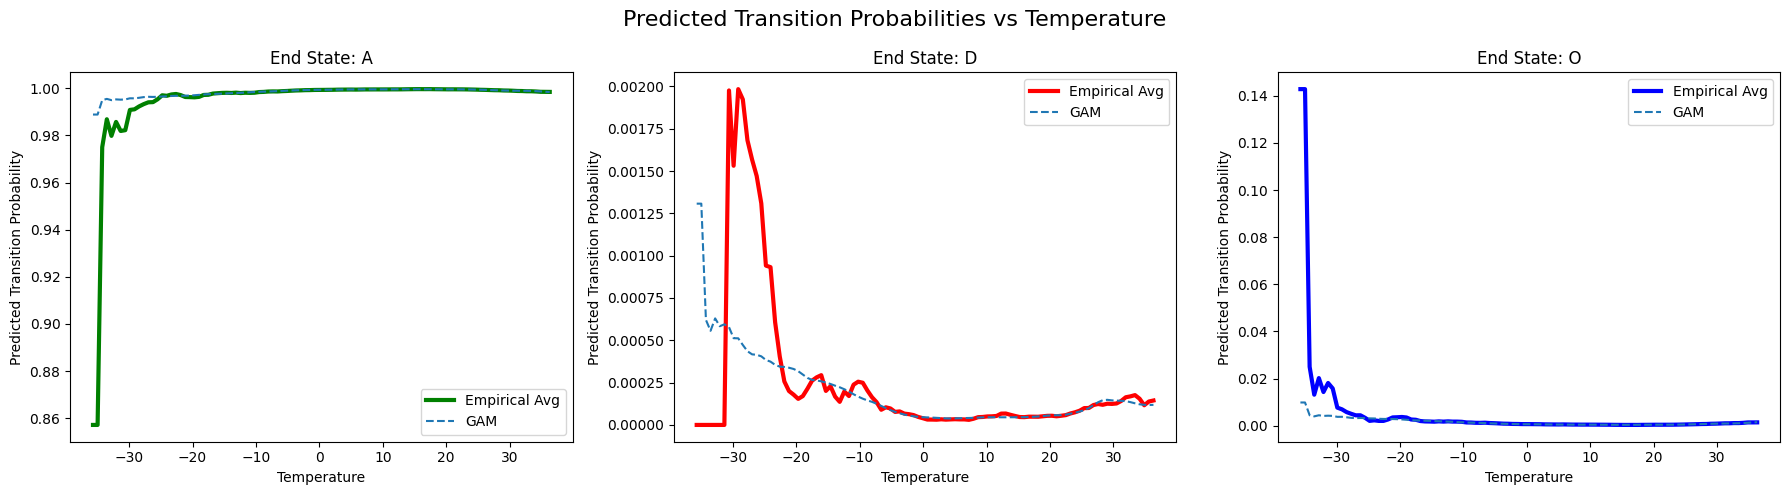

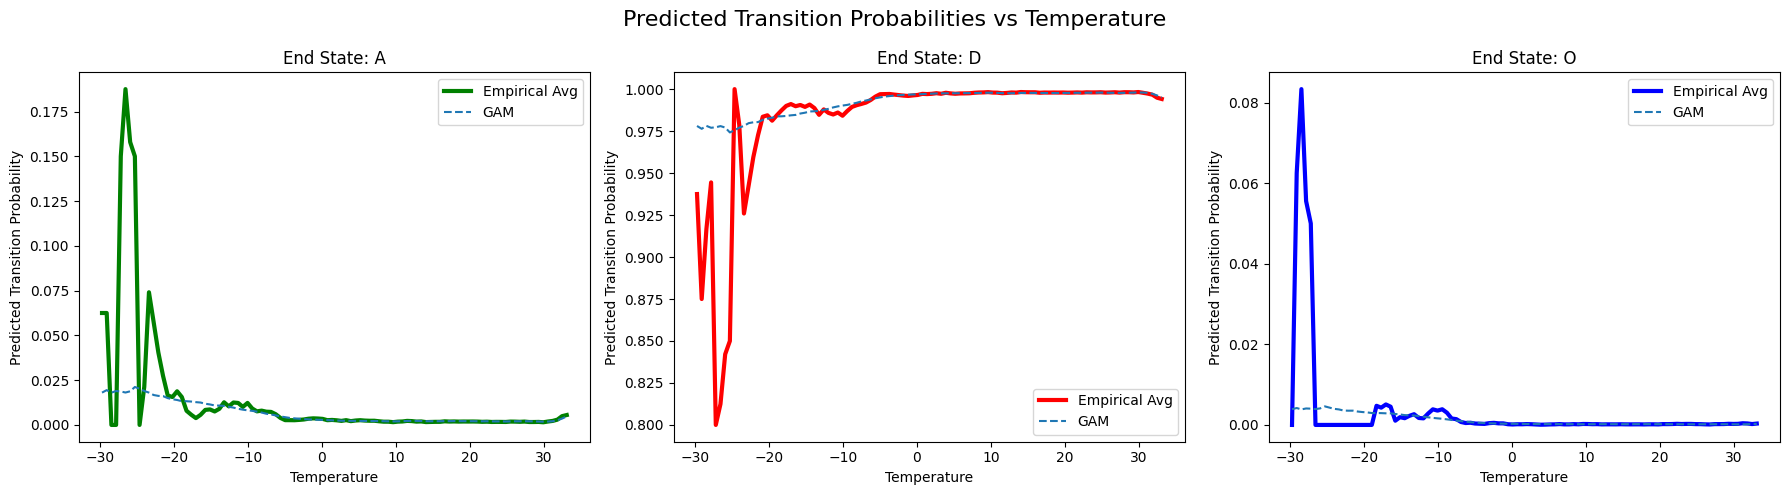

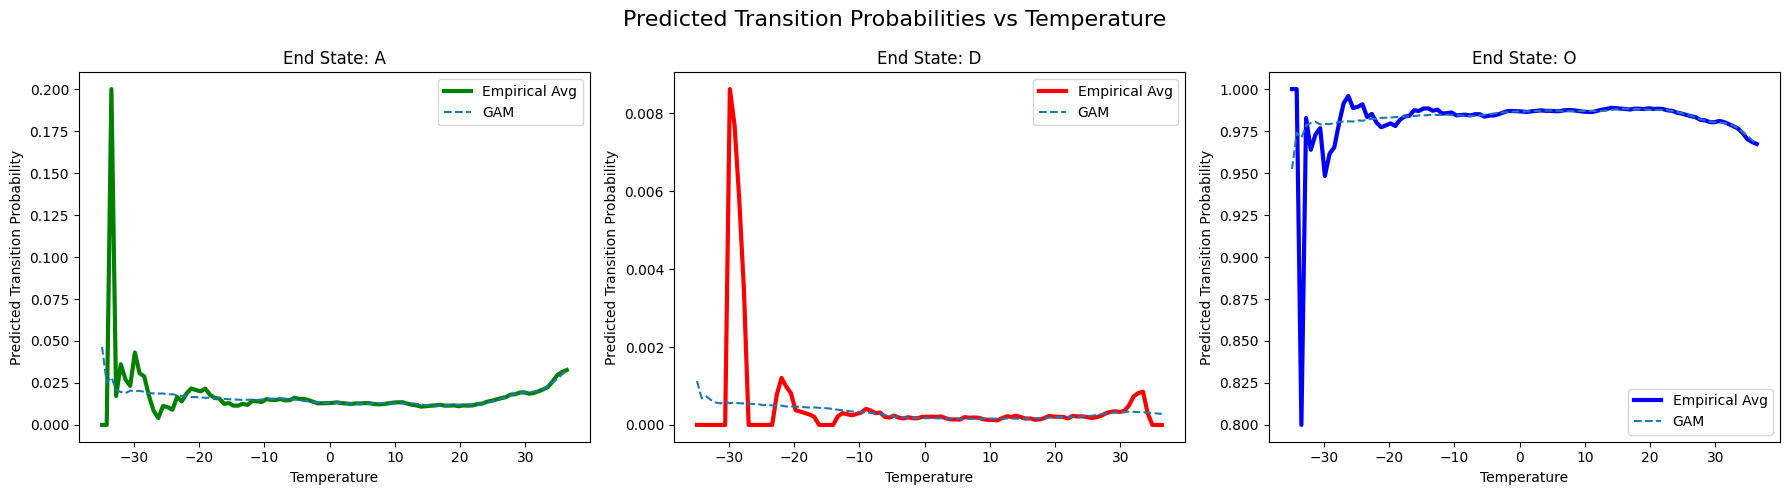

In [110]:
plot_prob_inference_transitions('Temperature', features, transition_models, test_datasets)

## Stress-Stratified Evaluation

In [116]:
q = [0.5, 0.9, 0.99]

test_data_stress_bins_per_state = defaultdict(dict)
for state in test_datasets.keys():
    test_data = test_datasets[state]
    w_stress = test_data['w_stress']
    q_stress_bin_edges = np.quantile(w_stress, q)

    test_data_stress_bins_per_state[state] = {
        'Low': test_data.loc[test_data['w_stress'] < q_stress_bin_edges[0]],
        'Medium': test_data.loc[(test_data['w_stress'] >= q_stress_bin_edges[0]) & (test_data['w_stress'] < q_stress_bin_edges[1])],
        'High': test_data.loc[(test_data['w_stress'] >= q_stress_bin_edges[1]) & (test_data['w_stress'] < q_stress_bin_edges[2])],
        'Very High': test_data.loc[test_data['w_stress'] >= q_stress_bin_edges[2]],
    }

In [117]:
def weighted_log_likelihood(y_true: np.ndarray, p_pred: np.ndarray, weights: np.ndarray) -> float:
    """Compute weighted log-likelihood for multi-class classification."""
    eps = 1e-12
    p_pred = np.clip(p_pred, eps, 1 - eps)
    log_likelihoods = np.log(p_pred[np.arange(len(y_true)), y_true])
    weighted_log_likelihood = np.sum(weights * log_likelihoods) / np.sum(weights)
    return weighted_log_likelihood


def weighted_calibration_error(y_bin, p, w, bin_edges, eps=1e-12):
    y_bin = np.asarray(y_bin, float).reshape(-1)
    p     = np.asarray(p, float).reshape(-1)
    w     = np.asarray(w, float).reshape(-1)

    p = np.clip(p, eps, 1 - eps)
    w = np.where(np.isfinite(w) & (w > 0), w, 0.0)

    edges = bin_edges

    total_w = w.sum()
    if total_w <= 0:
        return np.nan

    ece = {}
    for i in range(len(edges) - 1):
        left, right = edges[i], edges[i + 1]
        # include right edge in last bin
        if i == len(edges) - 2:
            m = (p >= left) & (p <= right)
        else:
            m = (p >= left) & (p < right)

        wb = w[m].sum()
        if wb <= 0:
            continue

        p_bar = np.sum(w[m] * p[m]) / wb
        y_bar = np.sum(w[m] * y_bin[m]) / wb
        # e = (wb / total_w) * abs(y_bar - p_bar)
        e = abs(y_bar - p_bar)
        ece[(left, right)] = e

    return ece


def weighted_Brier_score(y_bin, p, w, bin_edges):
    edges = bin_edges
    p     = np.asarray(p, float).reshape(-1)
    w     = np.asarray(w, float).reshape(-1)

    w = np.where(np.isfinite(w) & (w > 0), w, 0.0)
    brier_score = {}
    for i in range(len(edges) - 1):
        left, right = edges[i], edges[i + 1]
        # include right edge in last bin
        if i == len(edges) - 2:
            m = (p >= left) & (p <= right)
        else:
            m = (p >= left) & (p < right)

        wb = w[m].sum()
        if wb <= 0:
            continue

        bri = np.sum(w[m] * (y_bin[m] - p[m])**2) / wb
        brier_score[(left, right)] = bri
    return brier_score


def cal_curve(y_bin, p, w, bin_edges):
    edges = bin_edges
    p     = np.asarray(p, float).reshape(-1)
    w     = np.asarray(w, float).reshape(-1)

    w = np.where(np.isfinite(w) & (w > 0), w, 0.0)
    cal_score_p = {}
    cal_score_f = {}
    for i in range(len(edges) - 1):
        left, right = edges[i], edges[i + 1]
        # include right edge in last bin
        if i == len(edges) - 2:
            m = (p >= left) & (p <= right)
        else:
            m = (p >= left) & (p < right)

        wb = w[m].sum()
        if wb <= 0:
            continue

        p_ = np.sum(w[m] * p[m]) / wb
        f_ = np.sum(w[m] * y_bin[m]) / wb
        cal_score_p[(left, right)] = p_
        cal_score_f[(left, right)] = f_
    return cal_score_p, cal_score_f


In [119]:
n_prob_bins = 8

weights_stored = defaultdict(lambda: defaultdict(list))
p_test_stored = defaultdict(lambda: defaultdict(list))
y_test_stored = defaultdict(lambda: defaultdict(list))



for state in tqdm(transition_models.keys()):
    prob_models = transition_models[state]
    data = test_datasets[state]
    test_data_stress_bins = test_data_stress_bins_per_state[state]

    for initial_state_idx, initial_state in enumerate(['A', 'D', 'O']):
        # print(f"\nEvaluating initial MC state: {initial_state}")

        model = prob_models[initial_state]
        df = pd.concat([df for df in test_data_stress_bins.values()])
        try:
            p_test = model.predict_proba(df)
        except Exception as e:
            print(f"   Error processing state {state}, initial state {initial_state}: {e}")
            continue
        # prob_bin_edges = {}
        # for end_state in [0,1,2]:
        #     p_end_state = p_test[:, end_state]
        #     # prob_bin_edges[end_state] = np.linspace(p_end_state.min(), p_end_state.max(), 6)
        #     prob_bin_edges[end_state] = np.quantile(p_end_state, np.linspace(0, 1, 6))


        for stress_bin, test_data_bin in test_data_stress_bins.items():
            # print(f" Stress bin: {stress_bin} | N = {len(test_data_bin.loc[test_data_bin['Initial_gen_state'] == initial_state_idx])}")
            test_data_state = test_data_bin.loc[test_data_bin['Initial_gen_state'] == initial_state_idx].copy()
            if test_data_state.empty:
                print(f"   No data for region {state}, initial state {initial_state}, in stress bin {stress_bin}. Skipping.")
                continue
            p_test = model.predict_proba(test_data_state)
            y_test = test_data_state['Final_gen_state'].to_numpy(dtype=int)
            w_imp = test_data_state['w_stress'].to_numpy(dtype=float)
            w_cmp = test_data_state['Data_weight'].to_numpy(dtype=float)
            w_test = w_imp * w_cmp
            weights_stored[initial_state][stress_bin].append(w_test)
            p_test_stored[initial_state][stress_bin].append(p_test)
            y_test_stored[initial_state][stress_bin].append(y_test)

ll_results = defaultdict(dict)
weighted_calib_results = defaultdict(lambda: defaultdict(dict))
brier_results = defaultdict(lambda: defaultdict(dict))
calibration_curve_data = {'p':defaultdict(lambda: defaultdict(dict)), 
                          'f':defaultdict(lambda: defaultdict(dict))}
for init_state in ['A', 'D', 'O']:
    for stress_bin in weights_stored[init_state].keys():
        weights_concat = np.hstack(weights_stored[init_state][stress_bin])
        p_concat = np.vstack(p_test_stored[init_state][stress_bin])
        y_concat = np.hstack(y_test_stored[init_state][stress_bin])




        ll = weighted_log_likelihood(y_concat, p_concat, weights_concat)
        ll_results[init_state][stress_bin] = ll
            # print(f"    Weighted Log-Likelihood: {ll}")

        prob_bin_edges = {}
        for end_state in [0,1,2]:
            p_end_state = p_concat[:, end_state]
            # prob_bin_edges[end_state] = np.linspace(p_end_state.min(), p_end_state.max(), 6)
            prob_bin_edges[end_state] = np.quantile(p_end_state, np.linspace(0, 1, n_prob_bins+1))

        for end_state in [0,1,2]:
            y_bin = (y_concat == end_state).astype(float)
            p_bin = p_concat[:, end_state]

            # calib_err = weighted_calibration_error(y_bin, p_bin, w_test, n_bins=10, strategy="quantile")
            calib_err = weighted_calibration_error(y_bin, p_bin, weights_concat, prob_bin_edges[end_state])
            # brier     = weighted_Brier_score(y_bin, p_bin, w_test)
            brier     = weighted_Brier_score(y_bin, p_bin, weights_concat, prob_bin_edges[end_state])

            weighted_calib_results[init_state][stress_bin][end_state] = calib_err
            brier_results[init_state][stress_bin][end_state] = brier

            p,f = cal_curve(y_bin, p_bin, weights_concat, prob_bin_edges[end_state])
            calibration_curve_data['p'][init_state][stress_bin][end_state] = p
            calibration_curve_data['f'][init_state][stress_bin][end_state] = f
            # for e, cal in p.items():
            #     calibration_curve_data['p'][initial_state][stress_bin][end_state][e] = cal
            # for e, fi in f.items():
            #     calibration_curve_data['f'][initial_state][stress_bin][end_state][e] = fi


 17%|█▋        | 8/47 [00:05<00:27,  1.42it/s]

   No data for region NEW HAMPSHIRE, initial state D, in stress bin Low. Skipping.
   No data for region NEW HAMPSHIRE, initial state D, in stress bin Medium. Skipping.
   No data for region NEW HAMPSHIRE, initial state D, in stress bin High. Skipping.
   No data for region NEW HAMPSHIRE, initial state D, in stress bin Very High. Skipping.
   No data for region NEW HAMPSHIRE, initial state O, in stress bin Medium. Skipping.
   No data for region NEW HAMPSHIRE, initial state O, in stress bin High. Skipping.


 40%|████      | 19/47 [00:11<00:13,  2.02it/s]

   No data for region MAINE, initial state D, in stress bin Low. Skipping.
   No data for region MAINE, initial state D, in stress bin Medium. Skipping.
   No data for region MAINE, initial state D, in stress bin High. Skipping.
   No data for region MAINE, initial state D, in stress bin Very High. Skipping.


 72%|███████▏  | 34/47 [00:21<00:08,  1.47it/s]

   No data for region UTAH, initial state D, in stress bin Low. Skipping.


 79%|███████▊  | 37/47 [00:23<00:06,  1.45it/s]

   Error processing state KANSAS, initial state A: GAM has not been fitted. Call fit first.


100%|██████████| 47/47 [00:30<00:00,  1.53it/s]


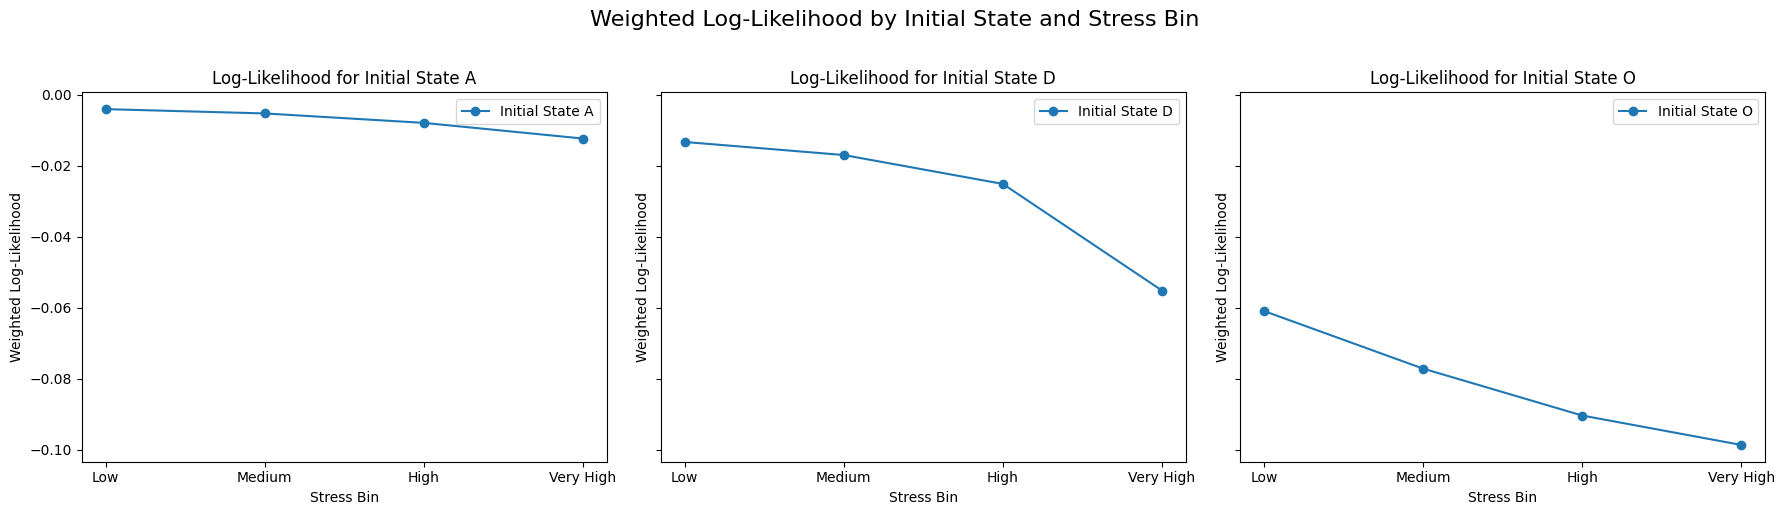

In [120]:
# plot results
# Log-Likelihood
ll_results_df = pd.DataFrame(ll_results).T
fig, axs = plt.subplots(1, 3, figsize=(18, 5), sharey=True)
i = 0
for init_state, row in ll_results_df.iterrows():
    axs[i].plot(row.index, row.values, marker='o', label=f'Initial State {init_state}')
    axs[i].set_title(f'Log-Likelihood for Initial State {init_state}')
    axs[i].set_xlabel('Stress Bin')
    axs[i].set_ylabel('Weighted Log-Likelihood')
    axs[i].legend()
    i += 1
plt.suptitle('Weighted Log-Likelihood by Initial State and Stress Bin', fontsize=16, y=1.02)
plt.tight_layout()
plt.show()


# # Weighted Calibration Error plots
# idx2state = {0:'A', 1:'D', 2:'O'}

# # Weighted Calibration Error
# fig, axs = plt.subplots(1, 3, figsize=(18, 5), sharey=True)
# i=0
# for init_state, state_results in weighted_calib_results.items():
#     print(state_results)
#     state_results_df = pd.DataFrame(state_results)
#     print(state_results_df)
#     for end_state, row in state_results_df.iterrows():
#         axs[i].plot(row.index, row.values, marker='o', label=f'To State {idx2state[end_state]}')
#     axs[i].set_title(f'Calibration Error for Initial State {init_state}')
#     axs[i].set_xlabel('Stress Bin')
#     axs[i].set_ylabel('Weighted Calibration Error')
#     axs[i].legend()
#     i += 1


# # Brier Score plots
# fig, axs = plt.subplots(1, 3, figsize=(18, 5), sharey=True)
# i=0
# for init_state, state_results in brier_results.items():
#     state_results_df = pd.DataFrame(state_results)
#     for end_state, row in state_results_df.iterrows():
#         axs[i].plot(row.index, row.values, marker='o', label=f'To State {idx2state[end_state]}')
#     axs[i].set_title(f'Brier Score for Initial State {init_state}')
#     axs[i].set_xlabel('Stress Bin')
#     axs[i].set_ylabel('Weighted Brier Score')
#     axs[i].legend()
#     i += 1

In [121]:
def _weighted_calib_to_df(weighted_calib_results):
    rows = []
    for init_state, d_stress in weighted_calib_results.items():
        for stress_bin, d_end in d_stress.items():
            for end_state, d_bins in d_end.items():
                for (l, r), err in d_bins.items():
                    rows.append({
                        "init_state": init_state,
                        "stress_bin": stress_bin,
                        "end_state": int(end_state),
                        "bin_left": float(l),
                        "bin_right": float(r),
                        "err": float(err),
                    })
    df = pd.DataFrame(rows)
    if df.empty:
        return df
    return df.sort_values(["init_state", "end_state", "stress_bin", "bin_left"]).reset_index(drop=True)

def _format_tick(v, mode="percent"):
    if mode == "percent":
        return f"{100*v:.0f}%"
    elif mode == "float":
        return f"{v:.4f}"
    else:  # "sci"
        return f"{v:.1e}"

def plot_calibration_bars_by_transition(
    result_dict,
    init_states=("A", "D", "O"),
    end_states=(0, 1, 2),
    stress_bins=("Low", "Medium", "High", "Very High"),
    end_state_labels=None,
    figsize=(18, 10),
    x_mode="left",             # "left" or "center"
    sharey=False,
    max_bins=40,
    test_name='Brier Score',
    n_xticks=8,                # how many tick labels to show
    xtick_format="percent",     # "percent" | "float" | "sci"
    ytick_format="percent"     # "percent" | "float" | "sci"
):
    # ---- consistent stress-bin colors (yellow -> red) ----
    cmap = plt.cm.YlOrRd
    stress_colors = {
        stress: cmap((i + 1) / (len(stress_bins) + 1))
        for i, stress in enumerate(stress_bins)
    }
    df = _weighted_calib_to_df(result_dict)
    if df.empty:
        raise ValueError("No data found in weighted_calib_results.")

    if end_state_labels is None:
        end_state_labels = {s: str(s) for s in end_states}

    nrows, ncols = len(init_states), len(end_states)
    fig, axs = plt.subplots(nrows, ncols, figsize=figsize, sharey=sharey)
    if nrows == 1:
        axs = np.expand_dims(axs, axis=0)
    if ncols == 1:
        axs = np.expand_dims(axs, axis=1)

    for i, init_state in enumerate(init_states):
        for j, end_state in enumerate(end_states):
            ax = axs[i, j]
            sub = df[(df["init_state"] == init_state) & (df["end_state"] == end_state)].copy()

            if sub.empty:
                ax.set_axis_off()
                continue

            bins = (
                sub[["bin_left", "bin_right"]]
                .drop_duplicates()
                .sort_values(["bin_left", "bin_right"])
                .to_numpy()
            )

            if len(bins) > max_bins:
                bins = bins[:max_bins]
                keep = set(map(tuple, bins))
                sub = sub[sub.apply(lambda r: (r["bin_left"], r["bin_right"]) in keep, axis=1)]

            nB = len(bins)
            x = np.arange(nB)

            k = len(stress_bins)
            group_width = 0.85
            bar_w = group_width / max(1, k)
            offsets = (np.arange(k) - (k - 1) / 2.0) * bar_w

            bin_to_idx = {(float(l), float(r)): idx for idx, (l, r) in enumerate(bins)}

            for s_idx, stress in enumerate(stress_bins):
                ss = sub[sub["stress_bin"] == stress]
                if ss.empty:
                    continue
                y = np.full(nB, np.nan, dtype=float)
                for row in ss.itertuples(index=False):
                    key = (float(row.bin_left), float(row.bin_right))
                    if key in bin_to_idx:
                        y[bin_to_idx[key]] = float(row.err)

                # ax.bar(x + offsets[s_idx], y, width=bar_w, label=stress)
                ax.bar(
                        x + offsets[s_idx],
                        y,
                        width=bar_w,
                        label=stress,
                        color=stress_colors[stress],
                        edgecolor="black",
                        linewidth=0.3,
                    )

            # ---- BETTER X AXIS TICKS (sparse + clean) ----
            if x_mode == "center":
                xvals = 0.5 * (bins[:, 0] + bins[:, 1])
                xlabel = "Probability bin (center)"
            else:
                xvals = bins[:, 0]
                xlabel = "Probability bin (left edge)"

            n_ticks = min(n_xticks, nB)
            tick_idx = np.unique(np.round(np.linspace(0, nB - 1, n_ticks)).astype(int))
            ax.set_xticks(tick_idx)
            ax.set_xticklabels([_format_tick(xvals[t], xtick_format) for t in tick_idx], rotation=0)
            ax.set_xlabel(xlabel if i == nrows - 1 else "")

            # ---- Y AXIS TICKS ----
            yvals = ax.get_yticks()
            n_ticks_y = len(yvals)
            # tick_idx_y = np.unique(np.round(np.linspace(0, len(yvals) - 1, n_ticks_y)).astype(int))
            ax.set_yticks(yvals)
            ax.set_yticklabels([_format_tick(y, ytick_format) for y in yvals])
            if j == 0:
                # ax.set_ylabel("Calibration error")
                ax.set_ylabel(test_name)

            if i == 0:
                ax.set_title(f"End state: {end_state_labels.get(end_state, end_state)}")
            if j == 0:
                # ax.set_ylabel(f"Init {init_state}\nCalib error")
                 ax.set_ylabel(f"Init {init_state}\n{test_name}")

            ax.grid(axis="y", alpha=0.3)

    handles, labels = axs[0, 0].get_legend_handles_labels()
    if handles:
        fig.legend(handles, labels, loc="upper center", ncol=min(len(stress_bins), 4), frameon=False)

    plt.tight_layout(rect=(0, 0, 1, 0.93))
    plt.show()

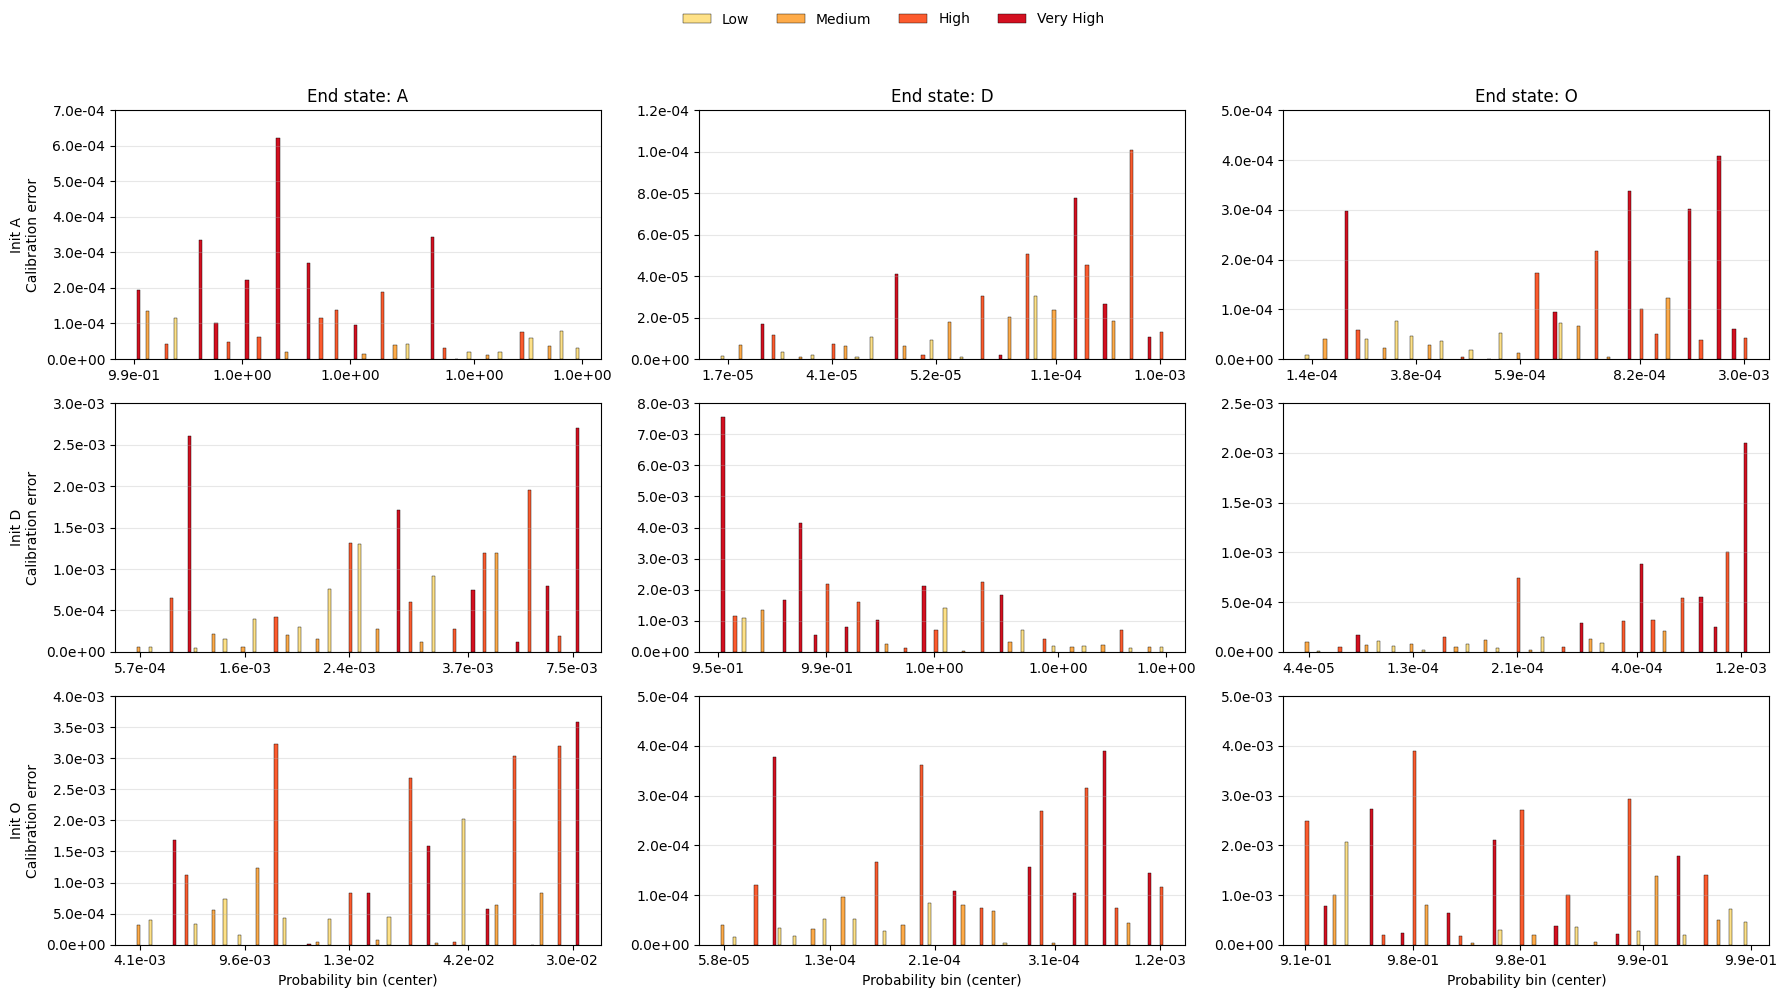

In [122]:
idx2state = {0:"A", 1:"D", 2:"O"}

plot_calibration_bars_by_transition(
    weighted_calib_results,
    init_states=("A","D","O"),
    end_states=(0,1,2),
    stress_bins=("Low","Medium","High","Very High"),
    end_state_labels=idx2state,
    x_mode="center",   # or "center"
    max_bins=30,      # tweak if you have tons of bins
    n_xticks=5,
    test_name='Calibration error',
    xtick_format="sci",
    ytick_format="sci"
)

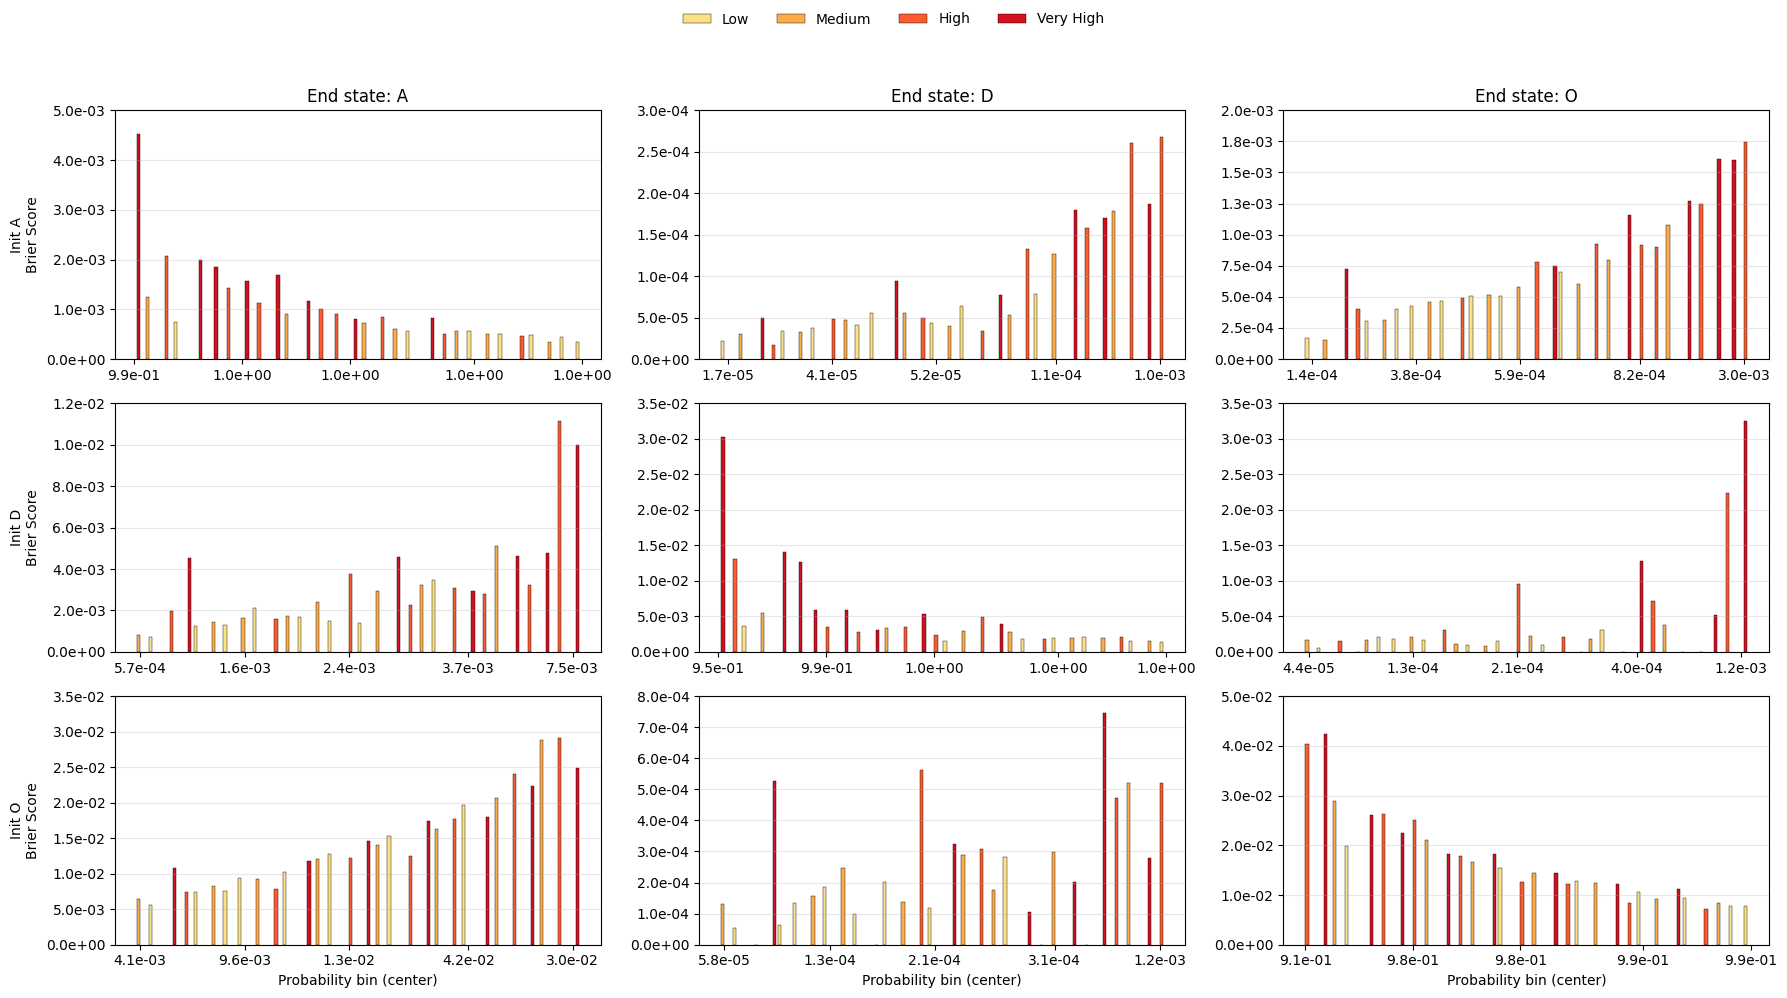

In [123]:
idx2state = {0:"A", 1:"D", 2:"O"}

plot_calibration_bars_by_transition(
    brier_results,
    init_states=("A","D","O"),
    end_states=(0,1,2),
    stress_bins=("Low","Medium","High","Very High"),
    end_state_labels=idx2state,
    x_mode="center",   # or "center"
    max_bins=30,      # tweak if you have tons of bins
    n_xticks=5,
    test_name='Brier Score',
    xtick_format="sci",
    ytick_format="sci"
)

In [124]:
def plot_calibration_by_transition(
    result_dict,
    init_states=("A", "D", "O"),
    end_states=(0, 1, 2),
    stress_bins=("Low", "Medium", "High", "Very High"),
    end_state_labels=None,        # e.g. {0:"A",1:"D",2:"O"}
    figsize=(18, 10),
    sharey=False,
    sharex=False,
    show_markers=True,
    marker_size=20,
    line_width=1.8,
    alpha=0.9,
    show_counts=False,            # if you later store counts per bin
):
    # --- labels ---
    if end_state_labels is None:
        end_state_labels = {s: str(s) for s in end_states}

    # --- consistent stress-bin colors (yellow -> red) ---
    cmap = plt.cm.YlOrRd
    stress_colors = {
        stress: cmap((i + 1) / (len(stress_bins) + 1))
        for i, stress in enumerate(stress_bins)
    }

    nrows, ncols = len(init_states), len(end_states)
    fig, axs = plt.subplots(nrows, ncols, figsize=figsize, sharex=sharex, sharey=sharey)

    if nrows == 1:
        axs = np.expand_dims(axs, axis=0)
    if ncols == 1:
        axs = np.expand_dims(axs, axis=1)

    # collect handles for a single shared legend
    legend_handles = {}
    perfect_handle = None

    for i, init_state in enumerate(init_states):
        for j, end_state in enumerate(end_states):
            ax = axs[i, j]

            # diagonal + formatting first
            # perfect_handle = ax.plot([0, 1], [0, 1], linestyle="--", linewidth=1.2, color="gray")[0]
            # ax.set_xlim(0, 1)
            # ax.set_ylim(0, 1)
            ax.set_aspect("equal", adjustable="box")
            ax.grid(True, alpha=0.25)
            ax.spines["top"].set_visible(False)
            ax.spines["right"].set_visible(False)

            # plot each stress bin
            any_curve = False
            max_val, min_val = 0.0, 1.0
            for stress in stress_bins:
                # your structure: result_dict['p'][init_state][stress][end_state] is dict of bins -> value
                try:
                    sub = list(result_dict["p"][init_state][stress][end_state].values())
                    f_sub = list(result_dict["f"][init_state][stress][end_state].values())
                except KeyError:
                    continue

                if len(sub) == 0 or len(f_sub) == 0:
                    continue

                # sort by predicted prob so lines don’t zig-zag
                sub = np.asarray(sub, dtype=float)
                f_sub = np.asarray(f_sub, dtype=float)
                order = np.argsort(sub)
                sub = sub[order]
                f_sub = f_sub[order]

                # h = ax.plot(
                #     sub,
                #     f_sub,
                #     linestyle="-",
                #     linewidth=line_width,
                #     color=stress_colors[stress],
                #     alpha=alpha,
                #     marker="o" if show_markers else None,
                #     markersize=marker_size,
                # )[0]
                h = ax.scatter(
                    sub,
                    f_sub,
                    color=stress_colors[stress],
                    alpha=alpha,
                    s=marker_size,
                )

                legend_handles.setdefault(stress, h)
                any_curve = True

                max_val = max([max_val, max(sub), max(f_sub)])
                min_val = min([ min_val, min(sub), min(f_sub)])
            
            perfect_handle = ax.plot([min_val, max_val], [min_val, max_val], linestyle="--", linewidth=1.2, color="gray")[0]

            if not any_curve:
                ax.set_axis_off()
                continue

            # titles + axis labels
            if i == 0:
                ax.set_title(f"End: {end_state_labels.get(end_state, end_state)}", fontsize=12)
            if j == 0:
                ax.set_ylabel(f"Init {init_state}\nObserved frequency", fontsize=11)
            if i == nrows - 1:
                ax.set_xlabel("Predicted probability", fontsize=11)

    # shared legend
    handles = [legend_handles[s] for s in stress_bins if s in legend_handles]
    labels = [s for s in stress_bins if s in legend_handles]
    if perfect_handle is not None:
        handles = handles + [perfect_handle]
        labels = labels + ["Perfect calibration"]

    if handles:
        fig.legend(handles, labels, loc="upper center", ncol=min(len(labels), 5), frameon=False)

    plt.tight_layout(rect=(0, 0, 1, 0.92))
    plt.show()

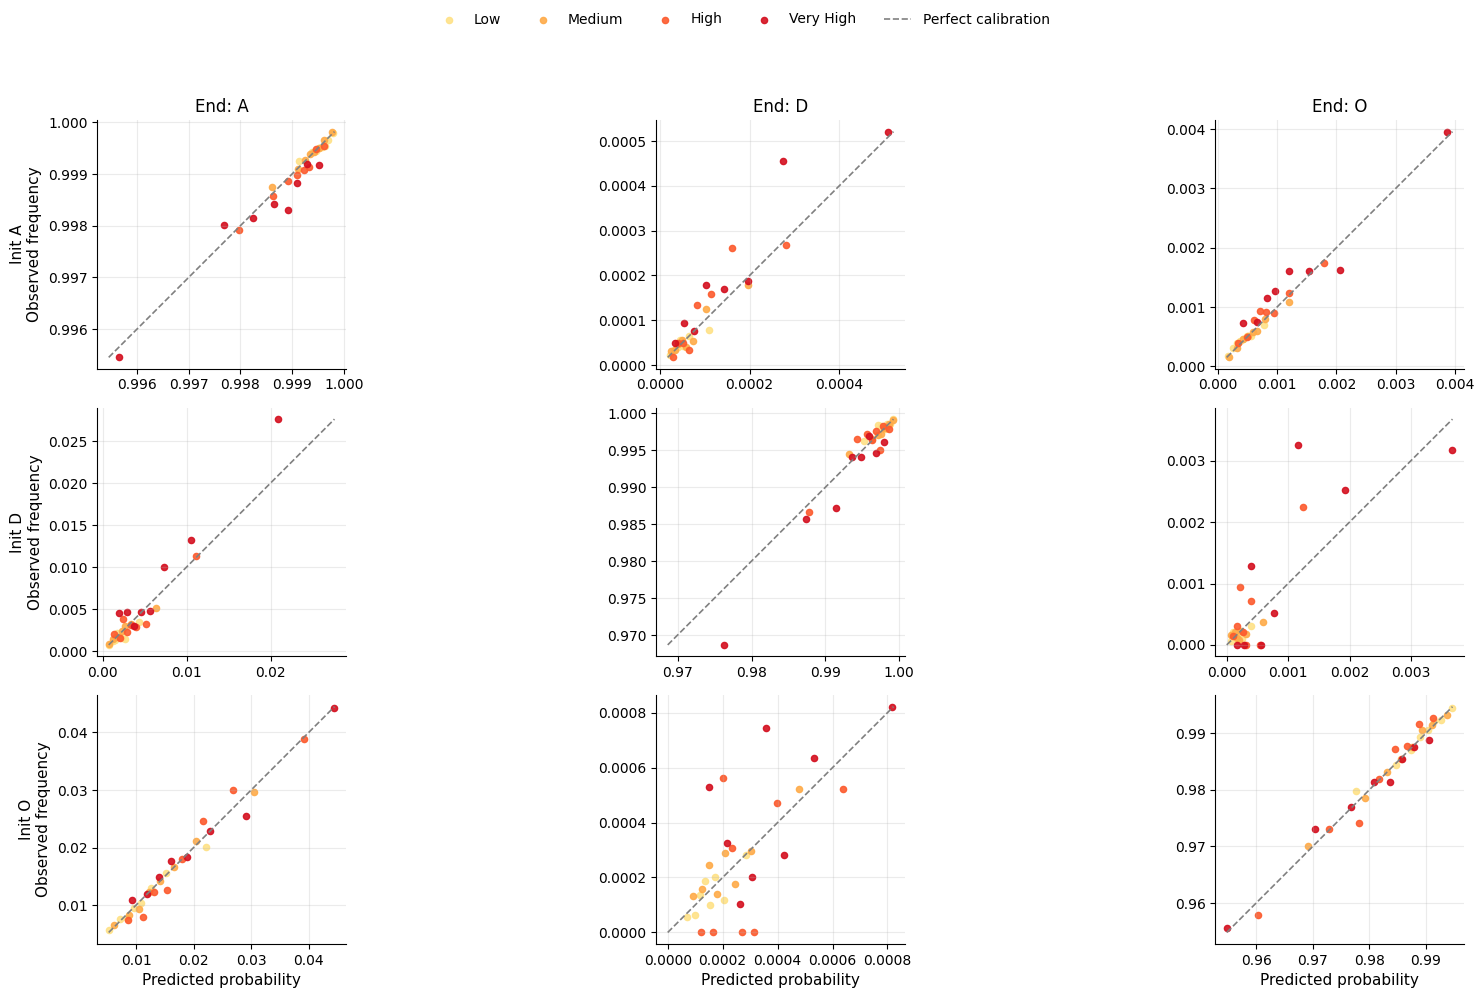

In [125]:
idx2state = {0:"A", 1:"D", 2:"O"}

plot_calibration_by_transition(
    calibration_curve_data,
    init_states=("A","D","O"),
    end_states=(0,1,2),
    stress_bins=("Low","Medium","High","Very High"),
    end_state_labels=idx2state,
)

### Calibration curves density

In [112]:
q = [0.5, 0.9, 0.99]

test_data_stress_bins_per_state = defaultdict(dict)
for state in test_datasets.keys():
    test_data = test_datasets[state]
    w_stress = test_data['w_stress']
    q_stress_bin_edges = np.quantile(w_stress, q)

    test_data_stress_bins_per_state[state] = {
        'Low': test_data.loc[test_data['w_stress'] < q_stress_bin_edges[0]],
        'Medium': test_data.loc[(test_data['w_stress'] >= q_stress_bin_edges[0]) & (test_data['w_stress'] < q_stress_bin_edges[1])],
        'High': test_data.loc[(test_data['w_stress'] >= q_stress_bin_edges[1]) & (test_data['w_stress'] < q_stress_bin_edges[2])],
        'Very High': test_data.loc[test_data['w_stress'] >= q_stress_bin_edges[2]],
    }

In [114]:
# weights_stored = defaultdict(lambda: defaultdict(list))
# count_stored = defaultdict(lambda: defaultdict(list))
p_test_stored = defaultdict(lambda: defaultdict(lambda: defaultdict(list)))
# y_test_stored = defaultdict(lambda: defaultdict(lambda: defaultdict(list)))
f_test_stored = defaultdict(lambda: defaultdict(lambda: defaultdict(list)))
c_test_stored = defaultdict(lambda: defaultdict(lambda: defaultdict(list)))

for state in tqdm(transition_models.keys()):
    prob_models = transition_models[state]
    data = test_datasets[state]
    test_data_stress_bins = test_data_stress_bins_per_state[state]

    for initial_state_idx, initial_state in enumerate(['A', 'D', 'O']):
        model = prob_models[initial_state]
        df = pd.concat([df for df in test_data_stress_bins.values()])
        try:
            p_test = model.predict_proba(df)

            for stress_bin, test_data_bin in test_data_stress_bins.items():
                
                test_data_state = test_data_bin.loc[test_data_bin['Initial_gen_state'] == initial_state_idx].copy()
                if test_data_state.empty:
                    print(f"   No data for region {state}, initial state {initial_state}, in stress bin {stress_bin}. Skipping.")
                    continue
                y_test = test_data_state['Final_gen_state'].to_numpy(dtype=int)
                p_test = model.predict_proba(test_data_state)
                w_cmp = test_data_state['Data_weight'].to_numpy(dtype=float)
                empirical_feq = CE_min(test_data_state, features)

                for end_state in [0,1,2]:
                    mask = (y_test == end_state).astype(bool)
                    p = p_test[mask, end_state]
                    f = empirical_feq[mask, end_state]
                    c = w_cmp[mask]
                    p_test_stored[initial_state][stress_bin][end_state].append(p)
                    f_test_stored[initial_state][stress_bin][end_state].append(f)
                    c_test_stored[initial_state][stress_bin][end_state].append(c)
        except Exception as e:
            print(f"   Error processing state {state}, initial state {initial_state}: {e}")
            continue


            
            
            # w_imp = test_data_state['w_stress'].to_numpy(dtype=float)
            # w_cmp = test_data_state['Data_weight'].to_numpy(dtype=float)
            # w_test = w_imp * w_cmp
            # weights_stored[initial_state][stress_bin].append(w_test)
            # p_test_stored[initial_state][stress_bin].append(p_test)
            # y_test_stored[initial_state][stress_bin].append(y_test)
            # count_stored[initial_state][stress_bin].append(w_cmp)
            # f_test_stored[initial_state][stress_bin].append(empirical_feq)


 19%|█▉        | 9/47 [00:06<00:23,  1.65it/s]

   No data for region NEW HAMPSHIRE, initial state D, in stress bin Low. Skipping.
   No data for region NEW HAMPSHIRE, initial state D, in stress bin Medium. Skipping.
   No data for region NEW HAMPSHIRE, initial state D, in stress bin High. Skipping.
   No data for region NEW HAMPSHIRE, initial state D, in stress bin Very High. Skipping.
   No data for region NEW HAMPSHIRE, initial state O, in stress bin Medium. Skipping.
   No data for region NEW HAMPSHIRE, initial state O, in stress bin High. Skipping.


 40%|████      | 19/47 [00:13<00:16,  1.67it/s]

   No data for region MAINE, initial state D, in stress bin Low. Skipping.
   No data for region MAINE, initial state D, in stress bin Medium. Skipping.
   No data for region MAINE, initial state D, in stress bin High. Skipping.
   No data for region MAINE, initial state D, in stress bin Very High. Skipping.


 72%|███████▏  | 34/47 [00:25<00:10,  1.21it/s]

   No data for region UTAH, initial state D, in stress bin Low. Skipping.


 79%|███████▊  | 37/47 [00:28<00:08,  1.19it/s]

   Error processing state KANSAS, initial state A: GAM has not been fitted. Call fit first.


100%|██████████| 47/47 [00:37<00:00,  1.27it/s]


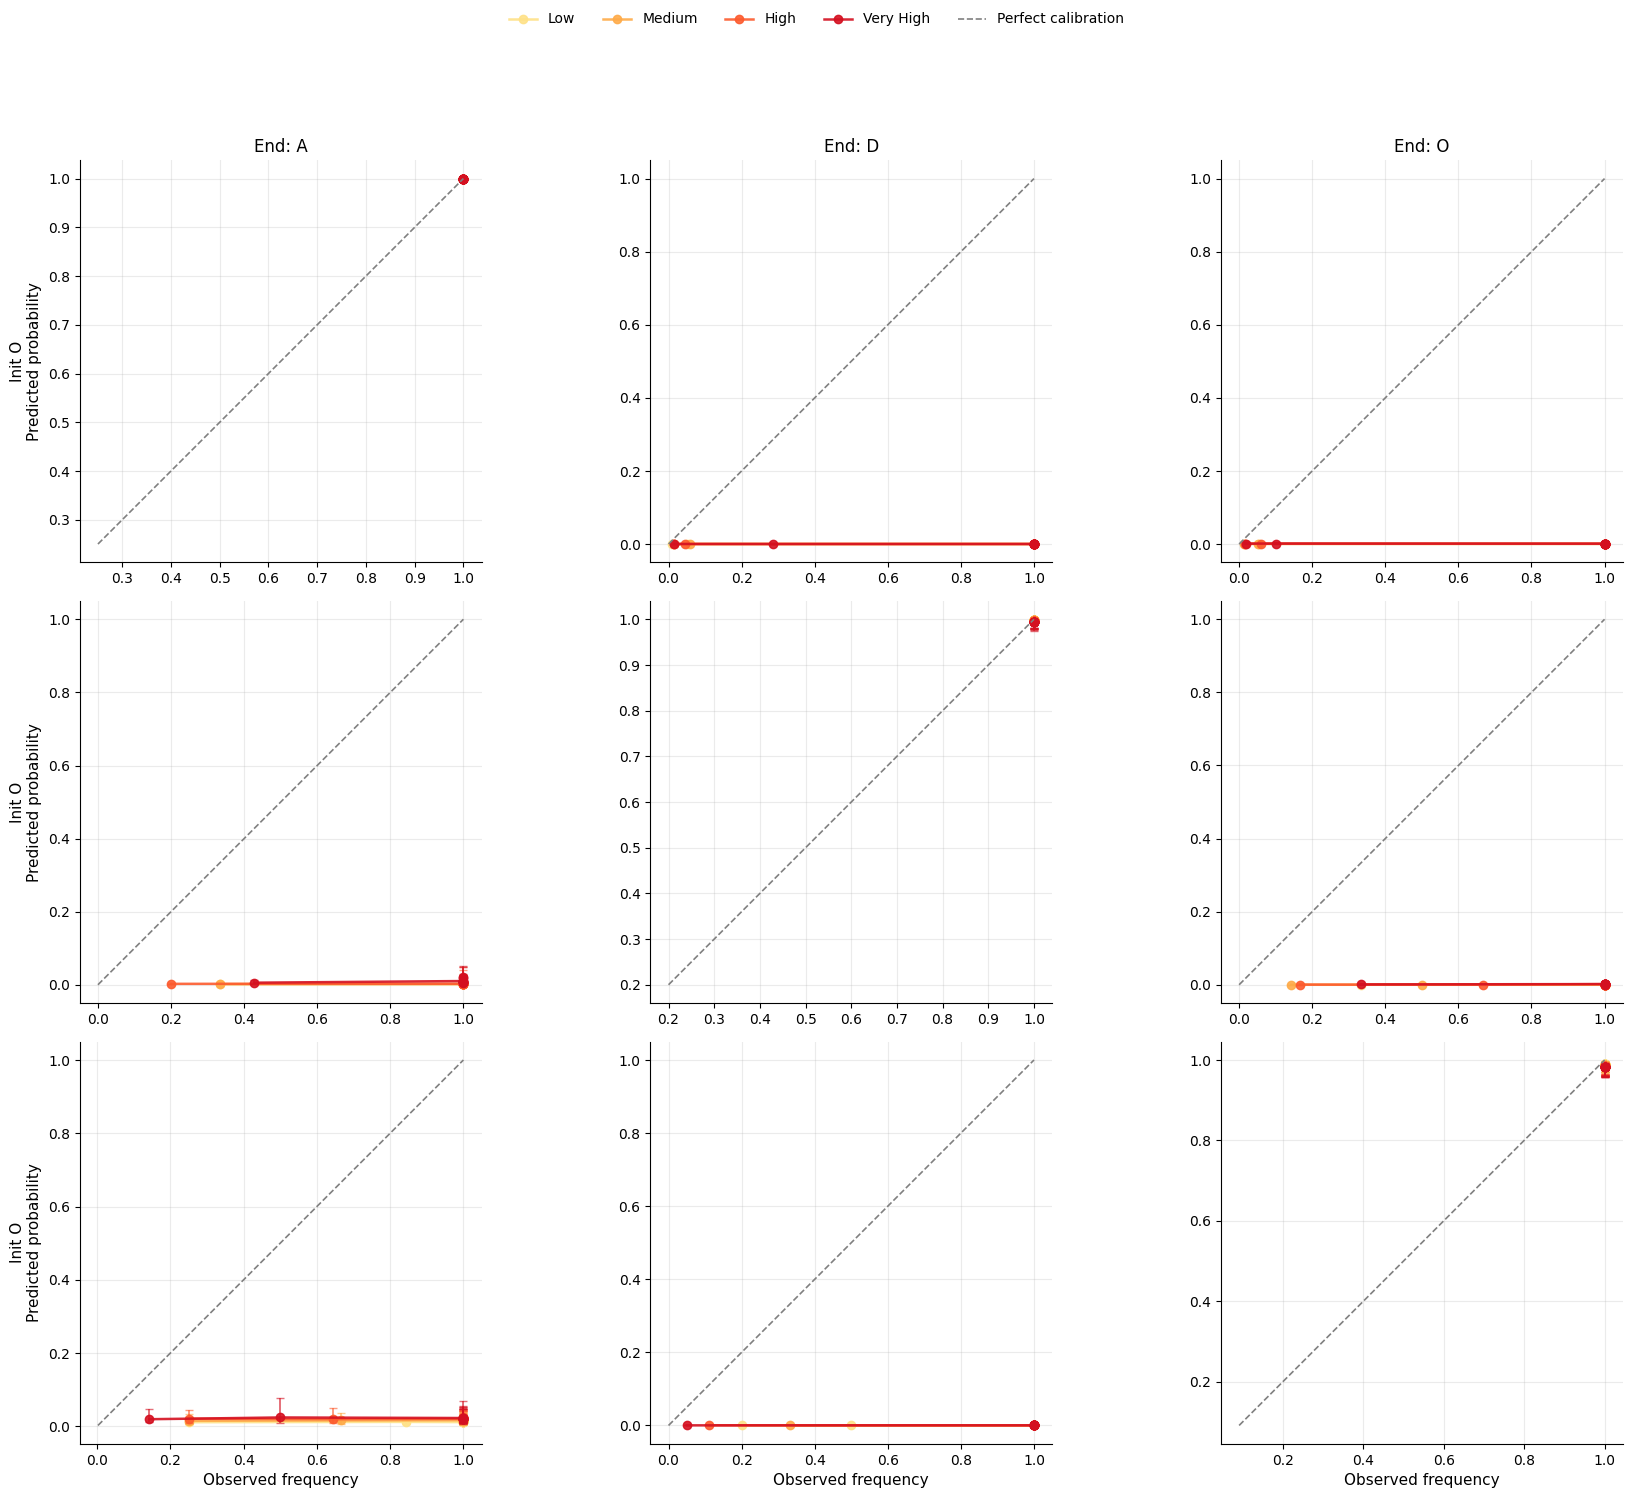

In [115]:

def plot_calibration_by_transition(
    result_dict,
    init_states=("A", "D", "O"),
    end_states=(0, 1, 2),
    stress_bins=("Low", "Medium", "High", "Very High"),
    end_state_labels=None,        # e.g. {0:"A",1:"D",2:"O"}
    n_points = 10,
    zones = [0.90]
):
    
    # --- labels ---
    if end_state_labels is None:
        end_state_labels = {s: str(s) for s in end_states}

    # --- consistent stress-bin colors (yellow -> red) ---
    cmap = plt.cm.YlOrRd
    stress_colors = {
        stress: cmap((i + 1) / (len(stress_bins) + 1))
        for i, stress in enumerate(stress_bins)
    }
    
    nrows, ncols = len(init_states), len(end_states)
    fig, axs = plt.subplots(nrows, ncols, figsize=(18, 15), sharex=False, sharey=False)
    if nrows == 1:
        axs = np.expand_dims(axs, axis=0)
    if ncols == 1:
        axs = np.expand_dims(axs, axis=1)


    # collect handles for a single shared legend
    legend_handles = {}
    perfect_handle = None

    for i, initial_state in enumerate(init_states):
        for j, end_state in enumerate(end_states):
            any_curve = False
            max_val, min_val = 0.0, 1.0
            for stress_bin in stress_bins:
                ax = axs[i,j]
                ax.set_aspect("equal", adjustable="box")
                ax.grid(True, alpha=0.25)
                ax.spines["top"].set_visible(False)
                ax.spines["right"].set_visible(False)

                p_concat = np.hstack(result_dict['p'][initial_state][stress_bin][end_state])
                f_concat = np.hstack(result_dict['f'][initial_state][stress_bin][end_state])
                c_concat = np.hstack(result_dict['c'][initial_state][stress_bin][end_state])
                f_concat = f_concat+np.random.normal(0, 1e-6, size=len(f_concat))
                if len(p_concat) == 0 or len(f_concat) == 0:
                    continue

                bin_edges = np.quantile(a=f_concat, q=np.linspace(0, 1, n_points + 1), weights=c_concat, method='inverted_cdf')

                medians = []
                bin_centers = []
                zones_L_bound = {z: [] for z in zones}
                zones_U_bound = {z: [] for z in zones}
                for k in range(len(bin_edges)-1):
                    left, right = bin_edges[k], bin_edges[k+1]
                    mask = (f_concat >= left) & (f_concat <= right) if k == len(bin_edges)-2 else (f_concat >= left) & (f_concat < right)
                    if np.sum(mask) == 0:
                        continue
                    f = f_concat[mask]
                    w = c_concat[mask]
                    median_f = np.quantile(f, 0.5, method='inverted_cdf', weights=w)
                    bin_centers.append(median_f)
                    p = p_concat[mask]
                    median_p = np.quantile(p, 0.5, method='inverted_cdf', weights=w)
                    medians.append(median_p)

                    for z in zones:
                        zone_bounds = np.quantile(p, [(1-z)/2, (1+z)/2], method='inverted_cdf', weights=w)
                        zones_L_bound[z].append(zone_bounds[0])
                        zones_U_bound[z].append(zone_bounds[1])
                        

                

                # h = ax.plot(bin_centers, medians, linestyle="-", linewidth=1.8, color=stress_colors[stress_bin], marker="o", markersize=6, alpha=0.9)[0]
                # for z in zones:
                #     ax.fill_between(bin_centers, zones_L_bound[z], zones_U_bound[z], color=stress_colors[stress_bin], alpha=0.2)
                # main calibration curve
                h = ax.plot(
                    bin_centers, medians,
                    linestyle="-", linewidth=1.8,
                    color=stress_colors[stress_bin],
                    marker="o", markersize=6, alpha=0.9
                )[0]

                # vertical error bars (single zone)
                z = zones[0]  # you always have one zone
                lower = np.array(zones_L_bound[z])
                upper = np.array(zones_U_bound[z])
                center = np.array(medians)

                yerr = np.vstack([center - lower, upper - center])

                ax.errorbar(
                    bin_centers, center,
                    yerr=yerr,
                    fmt="none",
                    ecolor=stress_colors[stress_bin],
                    elinewidth=1.4,
                    capsize=3,
                    alpha=0.6,
                )



                # h = ax.scatter(f_concat, p_concat, s=20, alpha=0.5, label=stress_bin, color=stress_colors[stress_bin])

                legend_handles.setdefault(stress_bin, h)
                any_curve = True

                m = min(p_concat)
                M = min(f_concat)
                min_val = min([min_val, min(p_concat), min(f_concat)])
                max_val = max([max_val, max(p_concat), max(f_concat)])
            if any_curve:
                perfect_handle = ax.plot([min_val, max_val], [min_val, max_val], linestyle="--", linewidth=1.2, color="gray")[0]

            if not any_curve:
                ax.set_axis_off()
                continue

            # titles + axis labels
            if i == 0:
                ax.set_title(f"End: {end_state_labels.get(end_state, end_state)}", fontsize=12)
            if j == 0:
                ax.set_ylabel(f"Init {init_state}\nPredicted probability", fontsize=11)
            if i == nrows - 1:
                ax.set_xlabel("Observed frequency", fontsize=11)

    # shared legend
    handles = [legend_handles[s] for s in stress_bins if s in legend_handles]
    labels = [s for s in stress_bins if s in legend_handles]
    if perfect_handle is not None:
        handles = handles + [perfect_handle]
        labels = labels + ["Perfect calibration"]

    if handles:
        fig.legend(handles, labels, loc="upper center", ncol=min(len(labels), 5), frameon=False)

    plt.tight_layout(rect=(0, 0, 1, 0.92))
    plt.show()


idx2state = {0:"A", 1:"D", 2:"O"}
plot_calibration_by_transition(result_dict={'p': p_test_stored, 'f': f_test_stored, 'c': c_test_stored}, end_state_labels=idx2state)